In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import seaborn as sns

from navi import haversine
from utils import prepare_dataframe

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import norm, uniform, randint

from xgboost import XGBRegressor

# North Pacific Ocean Tropical Depressions Novel Forecast Model

## Abstract

Building upon the foundational [analysis of the effects of the El Niño-Southern Oscillation (ENSO) on tropical depressions (TDs) in the North Pacific Ocean](https://github.com/StanDobrev11/enso_effect_on_npacific_tds), this current project takes the research a step further by developing a machine learning (ML) forecast model. The aim is to predict the track, intensity, and progression of tropical depressions based on their initial characteristics and ENSO phases.

In the previous project, correlations between ENSO phases and various tropical depression characteristics, such as frequency, intensity, and storm tracks were successfully identified, especially in the NE Pacific region. It was established that El Niño and La Niña events have discernible impacts on where and how frequently TDs form, as well as their overall intensity across the North Pacific region. This prior work provided valuable insights into how different ENSO conditions influence tropical depressions, laying a strong foundation for more advanced predictive modeling.

## Introduction

### Brief explanation of ENSO and TDs

The **El Niño-Southern Oscillation (ENSO)** is a climate phenomenon characterized by fluctuations in sea surface temperatures and atmospheric conditions in the Pacific Ocean. ENSO consists of three phases: **El Niño**, when ocean waters in the central and eastern Pacific are warmer than average; **La Niña**, when these waters are cooler than normal; and a **Neutral** phase when conditions are closer to the long-term average. ENSO has significant global impacts, affecting weather patterns, rainfall, and storm activity.

A **Tropical Depression (TD)** is a low-pressure weather system that typically develops around 5 degrees north or south of the equator. These systems are the early stage of tropical cyclones and can intensify into stronger storms, such as tropical storms or hurricanes, depending on favorable atmospheric and oceanic conditions. Key factors influencing the development of TDs include sea surface temperature, wind shear, latent heat, moisture, ENSO phase and the Coriolis effect, which helps initiate the system's rotation.

The current project focuses on the development of a machine learning-based forecast model designed to predict the future position, wind speed, and pressure of newly formed tropical depressions at 6-hour intervals. By leveraging historical tropical depression data and known ENSO phases, the model aims to predict the following:

- **TD Track**: The latitudinal and longitudinal coordinates of the storm’s future location.
- **Wind Speed**: Changes in the storm’s wind intensity.
- **Minimum Central Pressure**: Evolution of the storm’s pressure, which is critical for determining its potential strength.
- **Velocity and Direction**: Predict the movement speed and direction of the tropical depression.

Furthermore, as the tropical depression develops, newly acquired data will be incorporated into the model to improve the accuracy of forecasting its further evolution.

### Goals

1. The project aims to develope a series of machine learning models that will predict the future location, wind speed, pressure, and velocity of a tropical depression for the next 6, 12, 18, and 24 hours.
2. Compare the accuracy of different ML models to determine which performs best across varying prediction intervals, with the expectation that the 6-hour prediction will be the most reliable and the 24-hour forecast less so.
3. Evaluate the performance of the models in terms of bias, variance, and overall error using metrics like Mean Squared Error (MSE) and R-squared scores.
4. Optimize the models through grid search and other tuning methods to ensure the best possible performance.

### Steps to be Followed

1. **Data Preparation and Feature Engineering**: The datasets from the previous project will be used. Some of the features will be transformed and scaled, others will be engineered.

2. **Model Selection, Training and Testing**: The machine learning algorithms to be evaluated are Random Forest Regressor and Gradient Boosting Models (XGBoost). The dataset will be split into training and test sets, with cross-validation to ensure model robustness. Separate models will be trained for 6, 12, 18, and 24-hour prediction intervals, with the recursive use of previous predictions for longer intervals.

4. **Model Evaluation**: The performance of the models will be evaluated using metrics such as MSE, R-squared, and bias-variance tradeoffs. The accuracy of the predictions will be analyzed, particularly regarding the 6-hour, 12 and 24-hour predictions, with an expectation of decreasing accuracy for longer intervals.

5. **Optimization**: Hyperparameter tuning will be performed using grid search or randomized search to improve the models’ performance, especially in reducing prediction errors.

## Data Preparation and Feature Engineering

### Data Sources

The data used in this project comes from multiple reputable sources, ensuring comprehensive coverage of both tropical depression (TD) activity and environmental factors like sea surface temperature (SST) anomalies:

The SST anomaly data was obtained from the NASA Earth Data AQUA MODIS satellite, providing high-resolution sea surface temperature measurements. These anomalies reflect deviations from normal sea temperatures, which are critical for understanding the effects of El Niño and La Niña events. The data is in .nc format

Data for tropical depressions in the Northwest Pacific was sourced from the Japan Meteorological Agency (JMA). This dataset includes information on each tropical depression's intensity, minimum pressure, wind speeds, latitude, and longitude.

The National Hurricane Center (NHC) provided tropical depression data for the Northeast and Central Pacific, which is similar to the JMA data in terms of recorded metrics like wind speed, pressure, and storm tracks.

The ENSO phases (El Niño, La Niña, and Neutral) were derived from the ONI table provided by the Climate Prediction Center (CPC). The ONI is calculated as the rolling three-month mean SST anomaly in the Niño 3.4 region and is commonly used to identify ENSO phases.

The GSHHS (Global Self-consistent, Hierarchical, High-resolution Shoreline Database) was also utilized in this project to provide accurate geographical boundaries and coastlines for visualizing tropical depression tracks. This dataset offers detailed representations of global shorelines, which are essential for plotting storm trajectories in relation to landmasses and understanding potential landfall locations. GSHHS data ensures that the geospatial analysis of tropical depressions remains accurate and visually consistent when overlaying storm tracks on global maps.

The dataset from the previous project, which includes key information such as TD latitude, longitude, wind speed, minimum central pressure, and ENSO phase, will be further refined. Data cleaning steps included handling missing values, standardizing units, and aligning time formats. The full details of the data cleaning process can be found in the GitHub repository [here](https://github.com/StanDobrev11/enso_effect_on_npacific_tds), where the code for preprocessing is documented and accessible. This ensures the dataset is ready for further analysis and machine learning modeling.

Remaining missing wind data for the JMA dataset will be generated using a Random Forest model, and similarly, missing pressure data for the NHC dataset will be completed using the same method. Additional derived features, such as velocity and direction, will be included, with necessary transformations like trigonometric calculations for geographical coordinates. Features such as latitude, longitude, ENSO phase (one-hot encoded), wind speed, pressure, and the derived velocity and direction will be used to train the models, ensuring a comprehensive representation of tropical depression dynamics.

### Data Preparation

For data preparation, the function **prepare_dataframe()** is imported. Clear explanation of the transformation, performed on the dataframe, are described on the function's docstring. First, we will fill out the missing **wind** values from the JMA dataset.

In [3]:
# read jma data
jma = pd.read_csv('data/csv_ready/jma_td.csv', index_col=0)

# converting the longitude to standart values [-180:180]
jma['lon'] = jma['lon'].apply(lambda x: 360 - x if x > 180 else x)

# drop first row because first and second are same
jma = jma.drop(jma.index[0])

# add values for the wind, assuming minimum wind of the TD to be 35kn
jma.loc[jma['min_pressure_mBar'] >= 980, 'max_wind_kn'] = 35

In [4]:
jma = prepare_dataframe(jma)

During drafting of the project, Cartesian coordinates were used to transform the geographical latitude and longitude into a format that is easier for machine learning models to process. Latitude and longitude represent curved surfaces on Earth, but Cartesian coordinates allow the model to work with a flat, linear representation, making it easier to capture spatial relationships in a way that ML algorithms can interpret effectively. This helps improve the accuracy of the predictions.

Transforming the direction into sine and cosine components was done to avoid discontinuities that arise from using angles directly (since 0° and 360° are mathematically the same direction but numerically far apart). By using sine and cosine, the model can treat direction as a smooth, continuous feature, which better represents the cyclical nature of angles and helps improve learning efficiency.

Plane Sailing is a simplified navigational technique used to estimate the course and distance between two points on Earth, assuming that the Earth is flat for small distances. This method works by treating the meridians (lines of longitude) and parallels (lines of latitude) as straight lines, which allows for easy calculations using basic trigonometry. Plane sailing assumes a flat Earth, which introduces only small errors when dealing with short distances. Over small distances, the curvature of the Earth is minimal and can be safely ignored. This makes plane sailing a convenient and fast method for navigation over distances typically less than 600 nautical miles (NM) and therefore, for calculating course and speed of TDs for time intervals of 6 hours.

In the case of tropical depressions (TD), the speed and direction (or velocity and bearing) are relevant to describe the movement from one point to the next. When at point 0 (initial observation), we don't know the speed and direction until next observation position after 6 hours. Shifting the speed and direction by -1 ensures that at each point, the actual speed and direction required to reach the next point are used and the very last observation will have the speed and direction set to 0 to reflect TD's disipation.

Further testing of the models revealed that using Cartesian coordinates instead of latitude and longitude, as well as transforming direction into its sine and cosine components, did not improve performance. The results obtained from models trained on the transformed data were equivalent to those trained on the original latitude, longitude, and direction values, suggesting that these transformations provided no added benefit for this particular task.

In [5]:
jma[:10]

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z
date,,,,,,,,,,,,,,
1951-02-19 12:00:00,1,UNNAMED,20.0,138.5,35,1010,-1,45.0,48.0,0.743145,0.669131,-0.703788,0.622659,0.342020
1951-02-19 18:00:00,1,UNNAMED,23.0,142.1,35,1000,-1,40.9,61.0,0.874620,0.484810,-0.726356,0.565453,0.390731
1951-02-20 00:00:00,1,UNNAMED,25.0,146.0,35,994,-1,48.8,58.0,0.848048,0.529919,-0.751363,0.506801,0.422618
1951-02-20 06:00:00,1,UNNAMED,27.6,150.6,35,994,-1,27.1,61.0,0.874620,0.484810,-0.772073,0.435041,0.463296
1951-02-20 12:00:00,1,UNNAMED,28.9,153.3,35,994,-1,43.5,57.0,0.838671,0.544639,-0.782115,0.393363,0.483282
1951-02-20 18:00:00,1,UNNAMED,31.3,157.5,35,992,-1,41.1,72.0,0.951057,0.309017,-0.789417,0.326987,0.519519
1951-02-21 00:00:00,1,UNNAMED,32.6,162.1,35,990,-1,35.1,68.0,0.927184,0.374607,-0.801673,0.258933,0.538771
1951-02-21 06:00:00,1,UNNAMED,33.9,166.0,35,990,-1,38.9,57.0,0.838671,0.544639,-0.805357,0.200798,0.557745
1951-02-21 12:00:00,1,UNNAMED,36.0,170.0,35,990,-1,0.0,0.0,0.000000,1.000000,-0.796726,0.140484,0.587785


In [6]:
# the result of this line shows how many observation are missing the wind value
jma.max_wind_kn[jma.max_wind_kn == 0].count()

np.int64(6743)

In [7]:
# separate the dataframe
available_data_jma = jma[jma['max_wind_kn'] > 0]
predicted_data_jma = jma[jma['max_wind_kn'] == 0]

X_raw_jma = available_data_jma[['min_pressure_mBar', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]
y_raw_jma = available_data_jma['max_wind_kn']

# splitting the data 80/20 sounds reasonable. There are abt 62000 valid observations
X_train_jma, X_test_jma, y_train_jma, y_test_jma = train_test_split(X_raw_jma, y_raw_jma, test_size=0.2, random_state=42)
X_pred_jma = predicted_data_jma[['min_pressure_mBar', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]

In [8]:
# building the pipeline
preprocessor_jma = ColumnTransformer([
    ('enso', OneHotEncoder(), ['enso']),
    ('scaler', MinMaxScaler(), ['min_pressure_mBar', 'velocity_kn']),
], remainder='passthrough', force_int_remainder_cols=False)

pipeline_jma = Pipeline([
    ('preprocess', preprocessor_jma),  # Apply scaling and encoding
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=97))
])

Splitting the data 80/20 means using 80% of the dataset (about 49,600 observations) for training the model and the remaining 20% (about 12,400 observations) for testing. This is a common practice to ensure the model has enough data to learn from while still reserving a significant portion for evaluating its performance on unseen data. The train_test_split function with random_state=42 ensures that the split is reproducible, meaning the same split can be obtained each time the code is run.

This pipeline automates the process of preparing the data and training the model for tropical depression forecasting.

First, the preprocessor step handles the data transformations: **ENSO phases** (El Niño, La Niña, Neutral) are one-hot encoded to convert the categorical data into a format that the model can understand.
**MinPressure** and **Velocity** are scaled using **Min-Max scaling** to normalize the values, making them easier for the model to interpret.
Next, the **RandomForestRegressor** is applied to the preprocessed data. This model uses multiple decision trees to predict the next values for wind speed, pressure, and coordinates based on the historical data and ENSO phase. The pipeline combines all of these steps, making it easier to train and test the model efficiently.

Then we fit the training data to the pipeline and evaluate the model:

In [9]:
pipeline_jma.fit(X_train_jma, y_train_jma)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['min_pressure_mBar',
                                                   'velocity_kn'])])),
                ('regressor', RandomForestRegressor(random_state=97))])

In [10]:
pipeline_jma.score(X_test_jma, y_test_jma)

0.990303709781599

In [11]:
y_pred = pipeline_jma.predict(X_test_jma)
print(f'Mean Squared Error: {mean_squared_error(y_test_jma, y_pred)}')

Mean Squared Error: 3.266533927429667


The result shows that the RandomForestRegressor model is performing very well on the test data, with a high accuracy score of 0.99 (which indicates the model is correctly predicting 99% of the variance in the data). The Mean Squared Error (MSE) of 3.26 also indicates that, on average, the model's predictions deviate by about 3.26 units (kn) from the actual values. This is a low error value, further suggesting that the model is making precise predictions. The value of 3.26 kn deviation in the range of 35 - 140 kn of wind is acceptable.

Further evaluation of the model's reliability and potential overfitting will not be conducted, as the model's output is intended solely for a one-time use to fill missing data in the dataset.

With that in mind, missing wind data will be now applied to the jma dataset and will check if there are any '0' values remaining.

In [12]:
predicted_winds = pipeline_jma.predict(X_pred_jma)
jma.loc[jma['max_wind_kn'] == 0, 'max_wind_kn'] = predicted_winds.astype(int)

In [13]:
jma.max_wind_kn[jma.max_wind_kn == 0].count()

np.int64(0)

In [14]:
importances = pipeline_jma.named_steps['regressor'].feature_importances_
feature_names = pipeline_jma.named_steps['preprocess'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                     Feature  Importance
3  scaler__min_pressure_mBar    0.986765
9               remainder__z    0.002938
8               remainder__y    0.002371
7               remainder__x    0.002182
4        scaler__velocity_kn    0.002112
5   remainder__direction_sin    0.001411
6   remainder__direction_cos    0.001330
0              enso__enso_-1    0.000358
2               enso__enso_1    0.000289
1               enso__enso_0    0.000244


The feature importance table shows how much each feature contributes to the model's predictive power. In this case, min_pressure_mBar is the most important feature by far, with a feature importance score of 0.986759. This suggests that the model relies heavily on the minimum central pressure to make accurate predictions. The remaining features, including the x, y, z cartesian coordinates, velocity_kn, direction_sin, direction_cos, and the ENSO phase encoded as one-hot variables, have much lower importance, indicating that their contribution to the model's performance is minimal in comparison. This suggests that the pressure plays a critical role in determining the outcome, while the other features provide only marginal improvements.

A similar operation will be performed on the NHC dataset; however, in this case, the missing values are for minimum central pressure. The pressure values that are to be modeled, have a negative value.

In [15]:
nhc = pd.read_csv('data/csv_ready/ne_pacific_td.csv', index_col=0)
# converting the longitude to standart values [-180:180]
nhc['lon'] = 180 - nhc['lon']

In [16]:
nhc = prepare_dataframe(nhc)

In [17]:
# building the pipeline
preprocessor_nhc = ColumnTransformer([
    ('enso', OneHotEncoder(), ['enso']),
    ('scaler', MinMaxScaler(), ['max_wind_kn', 'velocity_kn']),
], remainder='passthrough', force_int_remainder_cols=False)

pipeline_nhc = Pipeline([
    ('preprocess', preprocessor_nhc),  # Apply scaling and encoding
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=97))
])

In [18]:
# separate the dataframe
available_data_nhc = nhc[nhc['min_pressure_mBar'] > 0]
predicted_data_nhc = nhc[nhc['min_pressure_mBar'] < 0]

X_raw_nhc = available_data_nhc[['max_wind_kn', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]
y_raw_nhc = available_data_nhc['min_pressure_mBar']

# splitting the data 80/20 sounds reasonable. There are abt 62000 valid observations
X_train_nhc, X_test_nhc, y_train_nhc, y_test_nhc = train_test_split(X_raw_nhc, y_raw_nhc, test_size=0.2, random_state=97)
X_pred_nhc = predicted_data_nhc[['max_wind_kn', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]

In [19]:
pipeline_nhc.fit(X_train_nhc, y_train_nhc)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'velocity_kn'])])),
                ('regressor', RandomForestRegressor(random_state=97))])

In [20]:
pipeline_nhc.score(X_test_nhc, y_test_nhc)

0.9769212339900484

In [21]:
y_pred = pipeline_nhc.predict(X_test_nhc)
print(f'Mean Squared Error: {mean_squared_error(y_test_nhc, y_pred)}')

Mean Squared Error: 7.306479477463594


In [22]:
predicted_pressure = pipeline_nhc.predict(X_pred_nhc)
nhc.loc[nhc['min_pressure_mBar'] < 0, 'min_pressure_mBar'] = predicted_pressure.astype(int)

In [23]:
nhc.min_pressure_mBar[nhc.min_pressure_mBar < 0].count()

np.int64(0)

In [24]:
importances = pipeline_nhc.named_steps['regressor'].feature_importances_
feature_names = pipeline_nhc.named_steps['preprocess'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                    Feature  Importance
3       scaler__max_wind_kn    0.965944
8              remainder__y    0.009226
9              remainder__z    0.008146
7              remainder__x    0.005515
4       scaler__velocity_kn    0.003858
5  remainder__direction_sin    0.002820
6  remainder__direction_cos    0.002698
0             enso__enso_-1    0.000692
1              enso__enso_0    0.000630
2              enso__enso_1    0.000472


Now that the missing values for both datasets, JMA and NHC are completed, they are saved for further usage in ML.

In [25]:
# dropping columns not required and saving the datasets
jma = jma.drop(columns=['direction_sin', 'direction_cos', 'x', 'y', 'z'])
nhc = nhc.drop(columns=['direction_sin', 'direction_cos', 'x', 'y', 'z'])
# jma.to_csv('data/csv_ready/jma_training')
# nhc.to_csv('data/csv_ready/nhc_training')

## Model Selection, Training & Testing

**Conceptual Clarification of Prediction Setup**

The idea is to predict the next position, speed, and course based on how the storm reached the current position. For this:

**Training Data Setup:**

- Each row should include information on the storm's movement (speed and course) toward the current position as lagged features.
- The target variables (latitude, longitude, wind speed and minimum pressure) represent the next position's attributes.
Prediction:
- Input the current position and movement characteristics (speed, course, and lagged features) to predict the attributes of the next position.

The add_lags function creates lagged features by shifting data for specific columns grouped by storms (e.g., grouped by a unique identifier like storm_id). However, to make it more precise, the function is deriving speed and course directly from latitude/longitude.

In [26]:
def add_lags(df, features, n_lags, group_col):
    """
    Adds lagged features for time series grouped by a specific column.

    Args:
    - df (DataFrame): The input DataFrame.
    - features (list): List of feature names to lag.
    - n_lags (int): Number of lag periods.
    - group_col (str): Column to group by (e.g., 'storm_id').

    Returns:
    - DataFrame: The DataFrame with lagged features added.
    """
    for lag in range(1, n_lags + 1):
        for feature in features:
            df[f"{feature}_lag_{lag}"] = df.groupby(group_col)[feature].shift(lag)
    # Drop rows where lagged values are NaN due to shifting
    return df.dropna(subset=[f"{feature}_lag_{lag}" for feature in features])

### XGBRegressor Workflow and Adaptation for Time Series Prediction

XGBRegressor is incorporated into the project for its ability to model complex, non-linear relationships efficiently while maintaining robustness and scalability. Unlike linear models like SGDRegressor, XGBRegressor excels at handling structured time-series data by leveraging gradient boosting techniques to optimize predictions iteratively. This makes it a strong candidate for modeling tropical depression (TD) tracks and intensities.

For this project, XGBRegressor provides the flexibility to handle mixed data types (e.g., categorical and continuous features like ENSO phases, wind speed, latitude, and longitude) and allows for advanced feature engineering and custom loss functions. Its tree-based nature eliminates the need for extensive feature scaling, simplifying the preprocessing pipeline.

#### Workflow
1. **Data Preparation:**
   - Speed and course were calculated using latitude and longitude and shifted to align with the target positions.
   - ENSO phases were one-hot encoded to represent their influence effectively.
   - Lagged features were generated to incorporate historical movement patterns.

2. **Model Configuration:**
   - XGBRegressor will be configured with optimized hyperparameters.
   - A grid search or random search will be conducted to fine-tune these hyperparameters for optimal performance.

3. **Evaluation:**
   - The model will be evaluated on R² score.
   - Mean Absolute Error (MAE) will be used to quantify prediction accuracy.

4. **Visualization:**
   - Predicted storm tracks will be plotted alongside real observations, showing close alignment and validating the model's performance.

#### Key Insights
The XGBRegressor model effectively captured the non-linear relationships in the dataset and provided robust predictions for the next 6-hour positions, wind speed, and pressure of tropical depressions.

In [27]:
jma = pd.read_csv('data/csv_ready/jma_training', index_col=0)
jma.index = pd.to_datetime(jma.index)

In [28]:
jma.head()

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
1951-02-19 12:00:00,1,UNNAMED,20.0,138.5,35,1010,-1,45.0,48.0
1951-02-19 18:00:00,1,UNNAMED,23.0,142.1,35,1000,-1,40.9,61.0
1951-02-20 00:00:00,1,UNNAMED,25.0,146.0,35,994,-1,48.8,58.0
1951-02-20 06:00:00,1,UNNAMED,27.6,150.6,35,994,-1,27.1,61.0
1951-02-20 12:00:00,1,UNNAMED,28.9,153.3,35,994,-1,43.5,57.0


In [29]:
features = ['lat', 'lon', 'max_wind_kn', 'min_pressure_mBar', 'velocity_kn', 'direction_deg']
n_lags = 5
jma_lagged = add_lags(jma.copy(), features, n_lags=n_lags, group_col='group')

In [30]:
# List of lagged columns (attributes)
attrs = ['enso', 'group'] # Static feature
for i in range(1, 6):
    for feature in features:
        attrs.append(f'{feature}_lag_{i}')

# List of target columns
tgts = features.copy()


# Splitting attributes and targets
attrs = jma_lagged[attrs]
tgts = jma_lagged[tgts]

# Dropping velocity and direction since they will be computed rather than predicted
tgts = tgts.drop(columns=['velocity_kn', 'direction_deg'])

In [31]:
regressor_6 = MultiOutputRegressor(XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=97))
preprocessor_6 = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),  # One-hot encode the ENSO feature
    ], remainder='passthrough', force_int_remainder_cols=False)
scaler_6 = MinMaxScaler()

In [32]:
pipeline_jma_6 = Pipeline([
    ('preprocess', preprocessor_6),  # Apply encoding
    ('scaler', scaler_6), # Apply scaling
    ('regressor', regressor_6)
])

In [33]:
splitter = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=97)
groups = jma_lagged['group']

for train_idx, test_idx in splitter.split(attrs, tgts, groups):
    X_train, X_test = attrs.iloc[train_idx], attrs.iloc[test_idx]
    y_train, y_test = tgts.iloc[train_idx], tgts.iloc[test_idx]

In [34]:
X_train.head()

,enso,group,lat_lag_1,lon_lag_1,max_wind_kn_lag_1,min_pressure_mBar_lag_1,velocity_kn_lag_1,direction_deg_lag_1,lat_lag_2,lon_lag_2,...,max_wind_kn_lag_4,min_pressure_mBar_lag_4,velocity_kn_lag_4,direction_deg_lag_4,lat_lag_5,lon_lag_5,max_wind_kn_lag_5,min_pressure_mBar_lag_5,velocity_kn_lag_5,direction_deg_lag_5
date,,,,,,,,,,,,,,,,,,,,,
1951-02-20 18:00:00,-1,1,28.9,153.3,35.0,994.0,43.5,57.0,27.6,150.6,...,35.0,1000.0,40.9,61.0,20.0,138.5,35.0,1010.0,45.0,48.0
1951-02-21 00:00:00,-1,1,31.3,157.5,35.0,992.0,41.1,72.0,28.9,153.3,...,35.0,994.0,48.8,58.0,23.0,142.1,35.0,1000.0,40.9,61.0
1951-02-21 06:00:00,-1,1,32.6,162.1,35.0,990.0,35.1,68.0,31.3,157.5,...,35.0,994.0,27.1,61.0,25.0,146.0,35.0,994.0,48.8,58.0
1951-02-21 12:00:00,-1,1,33.9,166.0,35.0,990.0,38.9,57.0,32.6,162.1,...,35.0,994.0,43.5,57.0,27.6,150.6,35.0,994.0,27.1,61.0
1951-03-19 12:00:00,-1,2,7.0,162.5,35.0,998.0,10.4,73.0,6.7,161.4,...,35.0,1002.0,10.7,68.0,5.7,158.3,35.0,1002.0,11.3,75.0


In [35]:
y_train.head()

,lat,lon,max_wind_kn,min_pressure_mBar
date,,,,
1951-02-20 18:00:00,31.3,157.5,35,992
1951-02-21 00:00:00,32.6,162.1,35,990
1951-02-21 06:00:00,33.9,166.0,35,990
1951-02-21 12:00:00,36.0,170.0,35,990
1951-03-19 12:00:00,7.3,163.5,35,998


In [36]:
pipeline_jma_6.fit(X_train.drop(columns='group'), y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso'])])),
                ('scaler', MinMaxScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             de...
                                                             gamma=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=97, ...)))])

In [37]:
pipeline_jma_6.score(X_test.drop(columns='group'), y_test)

0.9810324311256409

In [38]:
X_test[:2]

,enso,group,lat_lag_1,lon_lag_1,max_wind_kn_lag_1,min_pressure_mBar_lag_1,velocity_kn_lag_1,direction_deg_lag_1,lat_lag_2,lon_lag_2,...,max_wind_kn_lag_4,min_pressure_mBar_lag_4,velocity_kn_lag_4,direction_deg_lag_4,lat_lag_5,lon_lag_5,max_wind_kn_lag_5,min_pressure_mBar_lag_5,velocity_kn_lag_5,direction_deg_lag_5
date,,,,,,,,,,,,,,,,,,,,,
1951-04-16 06:00:00,-1,3,9.2,147.2,35.0,1000.0,8.8,297.0,8.8,148.3,...,35.0,1002.0,10.3,287.0,8.0,151.5,35.0,1002.0,12.3,284.0
1951-04-16 12:00:00,-1,3,9.6,146.4,35.0,1000.0,10.7,304.0,9.2,147.2,...,35.0,1002.0,10.1,281.0,8.3,150.3,35.0,1002.0,10.3,287.0


In [39]:
y_test[:2]

,lat,lon,max_wind_kn,min_pressure_mBar
date,,,,
1951-04-16 06:00:00,9.6,146.4,35,1000
1951-04-16 12:00:00,10.2,145.5,35,1000


As we see, the lagged row of X_test dataframe
```
1951-04-16 06:00:00    -1	3	9.2	147.2	35.0	1000.0	8.8	...
```
is reflecting last 5 observation and will be passed to the model for predicting next observation, i.e 6-hours later expected position and attributes of the TD.
```
1951-04-16 06:00:00	9.6	146.4	35	1000
```


In [40]:
pipeline_jma_6.predict(X_test[:1])

array([[  9.621312, 146.46443 ,  35.150562, 998.6959  ]], dtype=float32)

The predicted values are a close match to the actual values. Now will select random 3 TDs and plot the actual against predicted data.

In [41]:
def manage_prediction(df, model):
    """
    Predict the next 6-hour position based on the input dataframe.

    Parameters:
    - df (pd.DataFrame): Input dataframe containing lagged features for prediction.
    - model: Trained machine learning model for predicting tropical depression attributes.

    Returns:
    - lat (float): Predicted latitude of the next position.
    - lon (float): Predicted longitude of the next position.
    - max_wind_kn (float): Predicted maximum wind speed in knots.
    - min_pressure_mBar (int): Predicted minimum central pressure in millibars.
    """

    predicted_values = model.predict(df)
    lat, lon, max_wind_kn, min_pressure_mBar = predicted_values[0]
    
    min_pressure_mBar = int(min_pressure_mBar)
    max_wind_kn = np.round(max_wind_kn, 1)
    
    return lat, lon, max_wind_kn, min_pressure_mBar

def get_groups(df, df_plot, n_samples, random_state):
    """
    Randomly select tropical depression groups for analysis and plotting.

    Parameters:
    - df (pd.DataFrame): The original dataset containing all observations.
    - df_plot (pd.DataFrame): The dataset used for predictions and plotting.
    - n_samples (int): Number of random groups to select.
    - random_state (int): Seed for reproducibility of the random selection.

    Returns:
    - groups (np.ndarray): Array of randomly selected group IDs.
    """
    np.random.seed(seed=random_state)
    samples = df_plot.group.unique()
    groups = np.random.choice(samples, size=n_samples)
    return groups


def plot_tds(df, df_plot, model, n_samples, random_state, lag=5):
    """
    Plot predicted vs. actual data for selected tropical depression groups.

    Parameters:
    - df (pd.DataFrame): The original dataset containing actual values.
    - df_plot (pd.DataFrame): The dataset used for predictions and plotting.
    - model: Trained machine learning model for predicting tropical depression attributes.
    - n_samples (int): Number of random tropical depression groups to plot.
    - random_state (int): Seed for reproducibility of the group selection.
    - lag (int): Number of lagged observations used for predictions.

    Returns:
    - None. Displays plots comparing predicted and actual tracks, wind speeds, and pressures.
    """
    groups = get_groups(df, df_plot, n_samples, random_state)
    # Number of groups
    num_groups = len(groups)

    # Set up subplots (3 plots per row): 3 plots for each group (Track, Wind, Pressure)
    num_cols = 3  # One column for each: Track, Wind, Pressure
    num_rows = num_groups  # One row per TD

    # Create subplots for lat/lon comparison, wind comparison, and pressure comparison
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))

    # Flatten axes to easily iterate
    axes = axes.reshape(num_rows, num_cols)

    # Loop through each group and make the plots
    for idx, group in enumerate(groups):
        # Select subplot axes for the current group: Track, Wind, Pressure
        track_ax = axes[idx, 0]  # Track (Lat/Lon)
        wind_ax = axes[idx, 1]  # Wind
        pressure_ax = axes[idx, 2]  # Pressure

        # Get the group data
        actual = df[df.group == group].copy()
        pred = df_plot[df_plot.group == group]

        # Lists to accumulate predicted values
        predicted_lons = []
        predicted_lats = []
        predicted_winds = []
        predicted_pressures = []

        # Adjust the range to account for the lag
        for i in range(lag, len(pred)):
            predicted = manage_prediction(pred[i - lag:i], model)  # Use lagged observations
            pred_lon, pred_lat = predicted[1], predicted[0]
            if pred_lon < 0:
                pred_lon += 360
            predicted_lons.append(pred_lon)
            predicted_lats.append(pred_lat)
            predicted_winds.append(predicted[2])
            predicted_pressures.append(predicted[3])

        # Plot predicted lat/lon as a line
        track_ax.plot(predicted_lons, predicted_lats, label="Predicted Track", c='b')
        actual['lon'] = actual['lon'].apply(lambda x: x if x >= 0 else 360 + x)
        track_ax.plot(actual.lon.iloc[lag:], actual.lat.iloc[lag:], c='r', label="Real Track")

        # Set labels and title for the track plot
        track_ax.set_title(f'Track (TD {actual.name.values[0]} ID: {group})')
        track_ax.set_xlabel('Longitude')
        track_ax.set_ylabel('Latitude')
        track_ax.legend()

        # Plot predicted and real wind speed
        wind_ax.plot(range(lag, len(pred)), predicted_winds, label="Predicted Wind", c='b')
        wind_ax.plot(range(lag, len(actual)), actual.max_wind_kn.iloc[lag:], c='r', label="Real Wind")
        wind_ax.set_title(f'Wind Speed Comparison (TD {actual.name.values[0]} ID: {group})')
        wind_ax.set_xlabel('Time Step')
        wind_ax.set_ylabel('Wind Speed (kn)')
        wind_ax.legend()

        # Plot predicted and real pressure
        pressure_ax.plot(range(lag, len(pred)), predicted_pressures, label="Predicted Pressure", c='b')
        pressure_ax.plot(range(lag, len(actual)), actual.min_pressure_mBar.iloc[lag:], c='r', label="Real Pressure")
        pressure_ax.set_title(f'Pressure Comparison (TD {actual.name.values[0]} ID: {group})')
        pressure_ax.set_xlabel('Time Step')
        pressure_ax.set_ylabel('Pressure (mBar)')
        pressure_ax.legend()

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

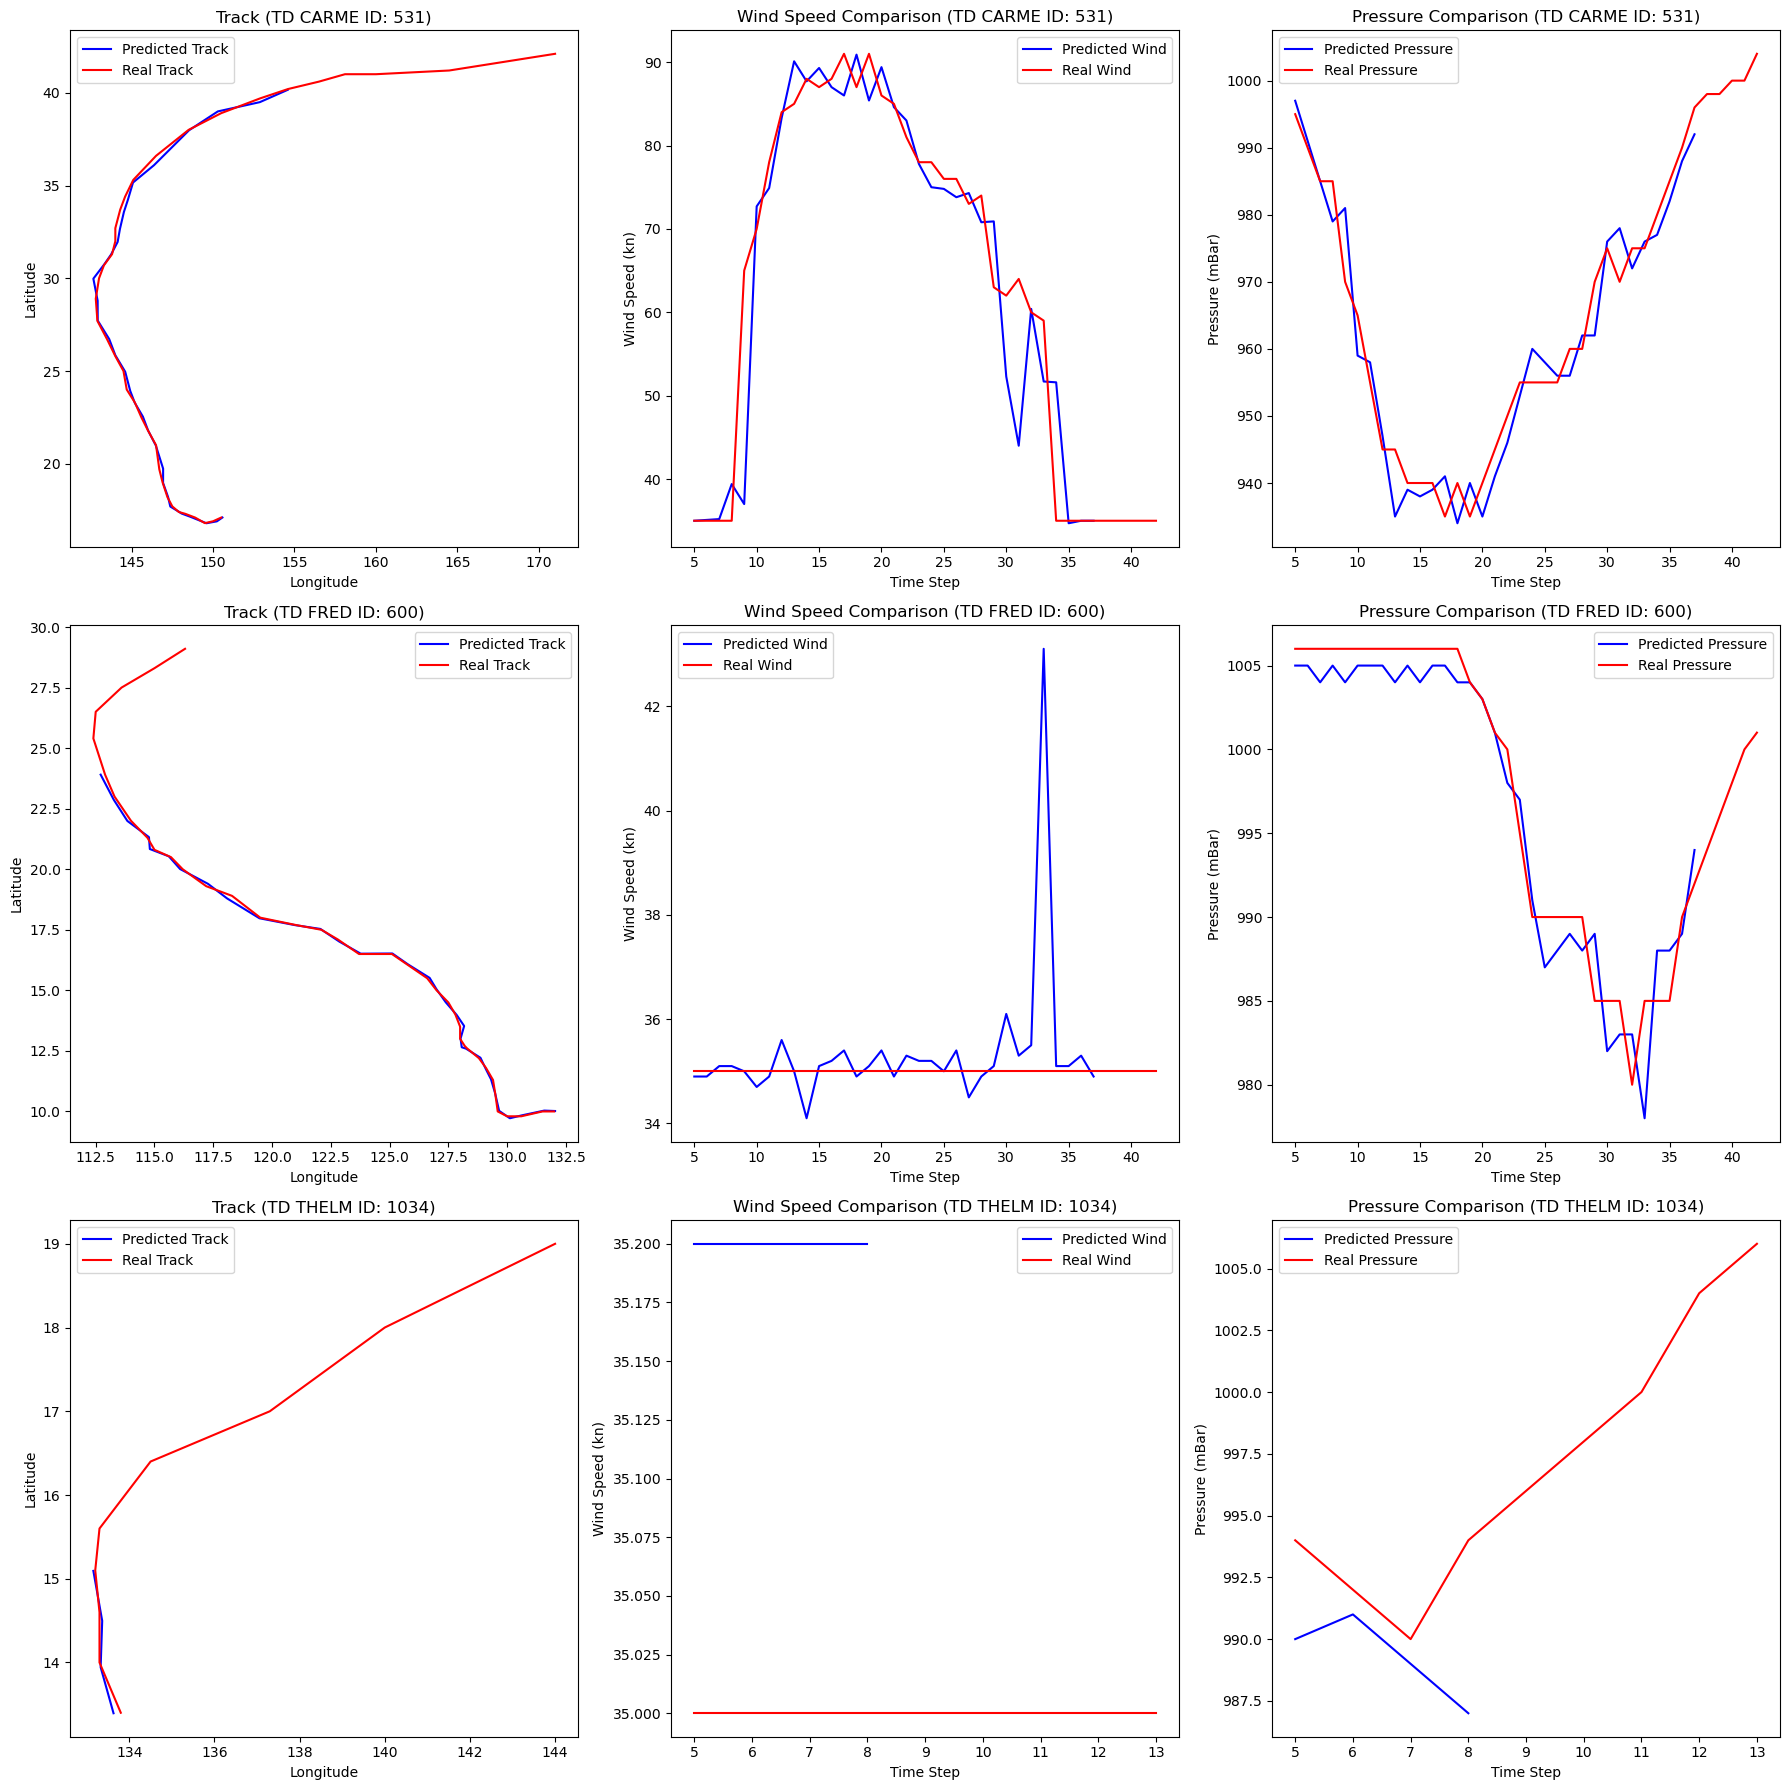

In [42]:
plot_tds(jma, X_test, pipeline_jma_6, n_samples=3, random_state=97)

The error will then be calculated in order to provide probability of predicted position in a radius of 30NM

In [43]:
def plane_sailing_course_speed(start_point, end_point, time_interval=6):
    """
    Calculates course and distance between 2 points using plane sailing approximation.

    :param start_point: tuple (lat1, lon1) in degrees
    :param end_point: tuple (lat2, lon2) in degrees
    :return: course (degrees), distance (nautical miles)
    """
    # Convert lat/lon to radians
    start_point = np.radians(np.array(start_point))
    end_point = np.radians(np.array(end_point))

    # Calculate delta lat (in radians)
    delta_lat = end_point[0] - start_point[0]

    # Calculate delta lon (in radians)
    delta_lon = end_point[1] - start_point[1]

    # Calculate the mean latitude (in radians)
    mean_lat = np.mean([start_point[0], end_point[0]])

    # Calculate the departure (in radians)
    dep = delta_lon * np.cos(mean_lat)

    # Calculate the course (in degrees)
    course = round(np.degrees(np.arctan2(dep, delta_lat)))
    if course < 0:
        course = 360 + course

    # Calculate the distance (in nautical miles)
    distance = np.sqrt(delta_lat ** 2 + dep ** 2) * 60 * 180 / np.pi  # Converting from radians to nautical miles
    speed = np.round(distance / time_interval, 1)

    return np.array([course, speed])

In [44]:
real = jma[jma.group == 2013][2:25]

In [45]:
# first 5 observations
initial_observations = jma[jma.group == 2013][7:12]

In [46]:
# lagged 5 observations to be passed to the model
initial_observations_lagged = X_test[X_test.group == 2013][7:8]

In [47]:
initial_observations

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
2015-11-18 12:00:00,2013,IN-F,6.2,154.7,35,994,1,12.0,312.0
2015-11-18 18:00:00,2013,IN-F,7.0,153.8,35,994,1,15.5,315.0
2015-11-19 00:00:00,2013,IN-F,8.1,152.7,35,994,1,14.2,295.0
2015-11-19 06:00:00,2013,IN-F,8.7,151.4,35,992,1,11.1,297.0
2015-11-19 12:00:00,2013,IN-F,9.2,150.4,35,985,1,11.5,301.0


In [48]:
initial_observations_lagged

,enso,group,lat_lag_1,lon_lag_1,max_wind_kn_lag_1,min_pressure_mBar_lag_1,velocity_kn_lag_1,direction_deg_lag_1,lat_lag_2,lon_lag_2,...,max_wind_kn_lag_4,min_pressure_mBar_lag_4,velocity_kn_lag_4,direction_deg_lag_4,lat_lag_5,lon_lag_5,max_wind_kn_lag_5,min_pressure_mBar_lag_5,velocity_kn_lag_5,direction_deg_lag_5
date,,,,,,,,,,,,,,,,,,,,,
2015-11-19 18:00:00,1,2013,9.2,150.4,35.0,985.0,11.5,301.0,8.7,151.4,...,35.0,994.0,15.5,315.0,6.2,154.7,35.0,994.0,12.0,312.0


In [49]:
def multiple_predictions(initial_observations, initial_observations_lagged, model, predictions=6):
    """
    Generate multiple 6-hour predictions for tropical depression positions and update the observation DataFrame.

    Parameters:
    - initial_observations (pd.DataFrame): 
        DataFrame containing the initial observations, including latitude, longitude, wind speed, pressure, etc.
    - initial_observations_lagged (pd.DataFrame): 
        DataFrame with lagged features derived from `initial_observations`, used as input for predictions.
    - model: 
        Trained machine learning model for predicting tropical depression attributes (e.g., latitude, longitude, etc.).
    - predictions (int, optional): 
        Number of 6-hour predictions to generate. Defaults to 6.

    Returns:
    - initial_observations (pd.DataFrame): 
        Updated DataFrame containing the original observations along with the appended predicted rows.
    """
    for _ in range(predictions):
        # First 6-hour prediction
        predicted = model.predict(initial_observations_lagged)[0]
        
        # Extract necessary values for the new row
        last_lat, last_lon = initial_observations['lat'].iloc[-1], initial_observations['lon'].iloc[-1]
        next_lat, next_lon = predicted[0], predicted[1]
        max_wind_kn = int(predicted[2])
        min_press_mBar = int(predicted[3])
        
        # Calculate direction and velocity
        direction_deg, velocity_kn = plane_sailing_course_speed([last_lat, last_lon], [next_lat, next_lon])
        
        # Create a new row with the predicted values
        new_row = initial_observations.iloc[-1].copy()
        new_row['lat'] = np.round(next_lat, 1)
        new_row['lon'] = np.round(next_lon, 1)
        new_row['max_wind_kn'] = max_wind_kn
        new_row['min_pressure_mBar'] = min_press_mBar
        new_row['direction_deg'] = direction_deg
        new_row['velocity_kn'] = velocity_kn
        
        # Add the new row to the DataFrame
        new_row_df = pd.DataFrame([new_row])
        new_row_df.index = [initial_observations.index[-1] + pd.Timedelta(hours=6)]
        initial_observations = pd.concat([initial_observations, new_row_df])
        
        
        
        features = ['lat', 'lon', 'max_wind_kn', 'min_pressure_mBar', 'velocity_kn', 'direction_deg']
        
        initial_observations_lagged = add_lags(initial_observations.copy(), features=features, n_lags=5, group_col='group')
        initial_observations_lagged = initial_observations_lagged.drop(columns='name')

        columns_to_move = ['enso']
        new_column_order = columns_to_move + [col for col in initial_observations_lagged if col not in columns_to_move]
        
        # Reorder the DataFrame
        initial_observations_lagged = initial_observations_lagged[new_column_order]

        initial_observations_lagged = initial_observations_lagged.drop(columns=['lat_lag_5', 'lon_lag_5', 'max_wind_kn_lag_5',
       'min_pressure_mBar_lag_5', 'velocity_kn_lag_5', 'direction_deg_lag_5'])

        lags = 5
        new_column_names = ['enso', 'group'] + [
            f"{feature}_lag_{lag}" for lag in range(1, lags + 1) for feature in features
        ]
        
        # Assign the dynamically generated column names
        initial_observations_lagged.columns = new_column_names
        initial_observations_lagged = initial_observations_lagged[-1:]

    return initial_observations


In [50]:
obs = multiple_predictions(initial_observations, initial_observations_lagged, pipeline_jma_6)

In [51]:
obs

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
2015-11-18 12:00:00,2013,IN-F,6.2,154.700000,35,994,1,12.0,312.0
2015-11-18 18:00:00,2013,IN-F,7.0,153.800000,35,994,1,15.5,315.0
2015-11-19 00:00:00,2013,IN-F,8.1,152.700000,35,994,1,14.2,295.0
2015-11-19 06:00:00,2013,IN-F,8.7,151.400000,35,992,1,11.1,297.0
2015-11-19 12:00:00,2013,IN-F,9.2,150.400000,35,985,1,11.5,301.0
2015-11-19 18:00:00,2013,IN-F,9.9,149.300003,37,982,1,12.5,302.0
2015-11-20 00:00:00,2013,IN-F,10.6,148.100006,43,979,1,13.4,301.0
2015-11-20 06:00:00,2013,IN-F,11.3,146.899994,56,973,1,13.7,302.0
2015-11-20 12:00:00,2013,IN-F,12.0,145.399994,62,970,1,16.4,296.0
2015-11-20 18:00:00,2013,IN-F,12.7,143.899994,66,965,1,16.2,295.0


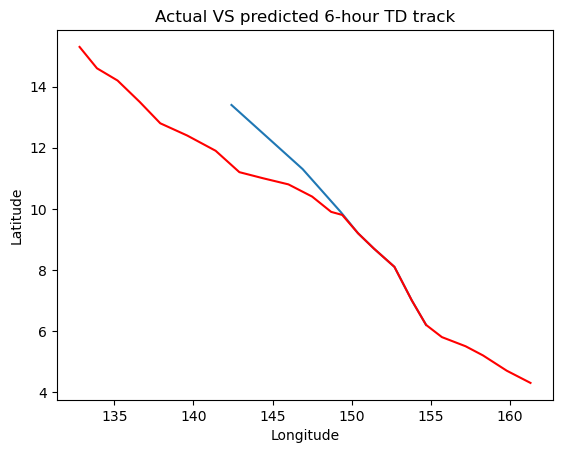

In [52]:
plt.plot(obs.lon, obs.lat)
plt.plot(real.lon, real.lat, c='r')
plt.title('Actual VS predicted 6-hour TD track')
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.show()

It is obvious that a separate model, prediction 12 and 24-hour position should be trained. The 6-hour prediction model does not preform well in long term predictions.

**Method to Calculate Probability of Predicted Position**

To calculate the probability of the predicted position being within a certain range of the actual position, we can use a statistical approach based on error distributions. The error distribution is calculated between predicted and real positions for the test dataset. Then we fit a normal distribution to the error values in terms of latitude and longitude differences. The standard deviation (σ) of the error distribution is used to estimate the confidence interval.

Using the fitted distribution, we calculate the probability that the actual position falls within a certain radius of the predicted position. We use the distance error to evaluate the models



In [53]:
# actual test data
y_test.head()

,lat,lon,max_wind_kn,min_pressure_mBar
date,,,,
1951-04-16 06:00:00,9.6,146.4,35,1000
1951-04-16 12:00:00,10.2,145.5,35,1000
1951-04-16 18:00:00,11.0,144.6,35,998
1951-04-17 00:00:00,11.7,144.0,35,998
1951-04-17 06:00:00,12.5,143.5,35,998


In [54]:
# lagged data 
X_test.head()

,enso,group,lat_lag_1,lon_lag_1,max_wind_kn_lag_1,min_pressure_mBar_lag_1,velocity_kn_lag_1,direction_deg_lag_1,lat_lag_2,lon_lag_2,...,max_wind_kn_lag_4,min_pressure_mBar_lag_4,velocity_kn_lag_4,direction_deg_lag_4,lat_lag_5,lon_lag_5,max_wind_kn_lag_5,min_pressure_mBar_lag_5,velocity_kn_lag_5,direction_deg_lag_5
date,,,,,,,,,,,,,,,,,,,,,
1951-04-16 06:00:00,-1,3,9.2,147.2,35.0,1000.0,8.8,297.0,8.8,148.3,...,35.0,1002.0,10.3,287.0,8.0,151.5,35.0,1002.0,12.3,284.0
1951-04-16 12:00:00,-1,3,9.6,146.4,35.0,1000.0,10.7,304.0,9.2,147.2,...,35.0,1002.0,10.1,281.0,8.3,150.3,35.0,1002.0,10.3,287.0
1951-04-16 18:00:00,-1,3,10.2,145.5,35.0,1000.0,11.9,312.0,9.6,146.4,...,35.0,1000.0,11.6,290.0,8.6,149.3,35.0,1002.0,10.1,281.0
1951-04-17 00:00:00,-1,3,11.0,144.6,35.0,998.0,9.1,320.0,10.2,145.5,...,35.0,1000.0,8.8,297.0,8.8,148.3,35.0,1000.0,11.6,290.0
1951-04-17 06:00:00,-1,3,11.7,144.0,35.0,998.0,9.4,329.0,11.0,144.6,...,35.0,1000.0,10.7,304.0,9.2,147.2,35.0,1000.0,8.8,297.0


In [55]:
def generate_prediction_df(df_x, df_y, model):
    """
    Generate a DataFrame containing real values and predicted values for latitude, longitude, 
    wind speed, and pressure using the provided model.

    Parameters:
    - df_x (pd.DataFrame): 
        Input features DataFrame used for predictions. Each row corresponds to an observation.
    - df_y (pd.DataFrame): 
        Ground truth DataFrame containing the actual values for comparison.
    - model: 
        Trained machine learning model for predicting latitude, longitude, wind speed, and pressure.

    Returns:
    - y_pred (pd.DataFrame): 
        DataFrame containing real values (`real_lat`, `real_lon`, etc.) and predicted values 
        (`pred_lat`, `pred_lon`, etc.).
    """
    y_pred = df_y.copy()
    for idx, row in df_x.iterrows():
        pred_lat, pred_lon, pred_wind, pred_press = model.predict(pd.DataFrame(row).T)[0]
        y_pred.at[idx, 'pred_lat'] = pred_lat
        y_pred.at[idx, 'pred_lon'] = pred_lon
        y_pred.at[idx, 'pred_wind'] = pred_wind
        y_pred.at[idx, 'pred_press'] = pred_press
    y_pred = y_pred.rename(columns={'lat': 'real_lat', 'lon': 'real_lon'})

    return y_pred

In [56]:
# below code to generate the dataframe
# y_pred_6 = generate_prediction_df(X_test, y_test, pipline_jma_6)

# predict position and add it as colum to y_pred
y_pred_6 = pd.read_csv('data/csv_ready/jma_pred.csv', index_col=0)
y_pred_6.index = pd.to_datetime(y_pred_6.index)

In [57]:
def probability_within_radius(df, radius_nm, steepness=1.0):
    """
    Calculate a smooth probability that the actual position is within a given radius
    (in nautical miles) of the predicted position.

    Parameters:
    - df: DataFrame with real and predicted latitudes and longitudes.
    - radius_nm: Radius in nautical miles for maximum probability.
    - steepness: Controls how sharply the probability decreases as the distance exceeds the radius.

    Returns:
    - DataFrame with a new column 'probability_within_radius'.
    """
    def calculate_errors(df):
        """
        Calculate the distance errors between predicted and real positions.
        """
        df['distance_error'] = df.apply(
            lambda row: haversine(
                [row['real_lat'], row['real_lon']],
                [row['pred_lat'], row['pred_lon']]
            ),
            axis=1
        )
        return df

    def sigmoid(x, radius, k):
        
        z = np.clip(k * (x - radius), -500, 500)
        return 1 / (1 + np.exp(z))


    # Step 1: Calculate distance errors
    df = calculate_errors(df)

    # Step 2: Apply sigmoid function to calculate smooth probabilities
    df['probability_within_radius'] = df['distance_error'].apply(
        lambda d: sigmoid(d, radius_nm, steepness)
    )

    return df


In [58]:
df_6 = probability_within_radius(y_pred_6, 30)

In [59]:
df_6

,real_lat,real_lon,max_wind_kn,min_pressure_mBar,pred_lat,pred_lon,pred_wind,pred_press,distance_error,probability_within_radius
date,,,,,,,,,,
1951-04-16 06:00:00,9.6,146.4,35,1000,9.621312,146.464430,35.150562,998.69590,4.023033,1.0
1951-04-16 12:00:00,10.2,145.5,35,1000,10.211706,145.544310,35.095260,998.76184,2.710989,1.0
1951-04-16 18:00:00,11.0,144.6,35,998,11.029076,144.599610,35.168835,998.90704,1.745888,1.0
1951-04-17 00:00:00,11.7,144.0,35,998,11.776751,143.858380,35.008250,996.73520,9.515401,1.0
1951-04-17 06:00:00,12.5,143.5,35,998,12.569205,143.572340,35.167950,996.67420,5.936396,1.0
...,...,...,...,...,...,...,...,...,...,...
2023-10-19 06:00:00,20.0,109.0,35,1002,20.001997,108.872140,35.030403,1001.58264,7.214758,1.0
2023-10-19 12:00:00,21.0,109.4,35,1000,20.975182,109.634580,34.936195,1002.22140,13.234065,1.0
2023-10-19 18:00:00,21.4,109.5,35,1002,21.454275,109.322426,35.063450,999.26940,10.446015,1.0


In [60]:
df_6.distance_error.mean()

np.float64(88.37075996389385)

In [61]:
df_6.distance_error.median()

np.float64(8.521994734256376)

In [62]:
def plot_distance_error(df):
    """
    Plot the distribution of distance errors using a histogram and a kernel density estimate (KDE).

    Parameters:
    - df (pd.DataFrame): 
        DataFrame containing a column named 'distance_error', which represents the error 
        between predicted and actual distances.

    Returns:
    - None: 
        Displays the histogram and KDE plots side by side.
    """

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram on the first subplot
    axes[0].hist(df['distance_error'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_title('Histogram of Distance Errors', fontsize=16)
    axes[0].set_xlabel('Distance Errors', fontsize=14)
    axes[0].set_ylabel('Frequency', fontsize=14)
    axes[0].grid(axis='y', alpha=0.75)
    
    # KDE on the second subplot
    sns.kdeplot(df['distance_error'], ax=axes[1], fill=True, color='blue')
    axes[1].set_title('Density Plot of Distance Errors', fontsize=16)
    axes[1].set_xlabel('Distance Errors', fontsize=14)
    axes[1].set_ylabel('Density', fontsize=14)
    axes[1].grid(axis='y', alpha=0.75)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

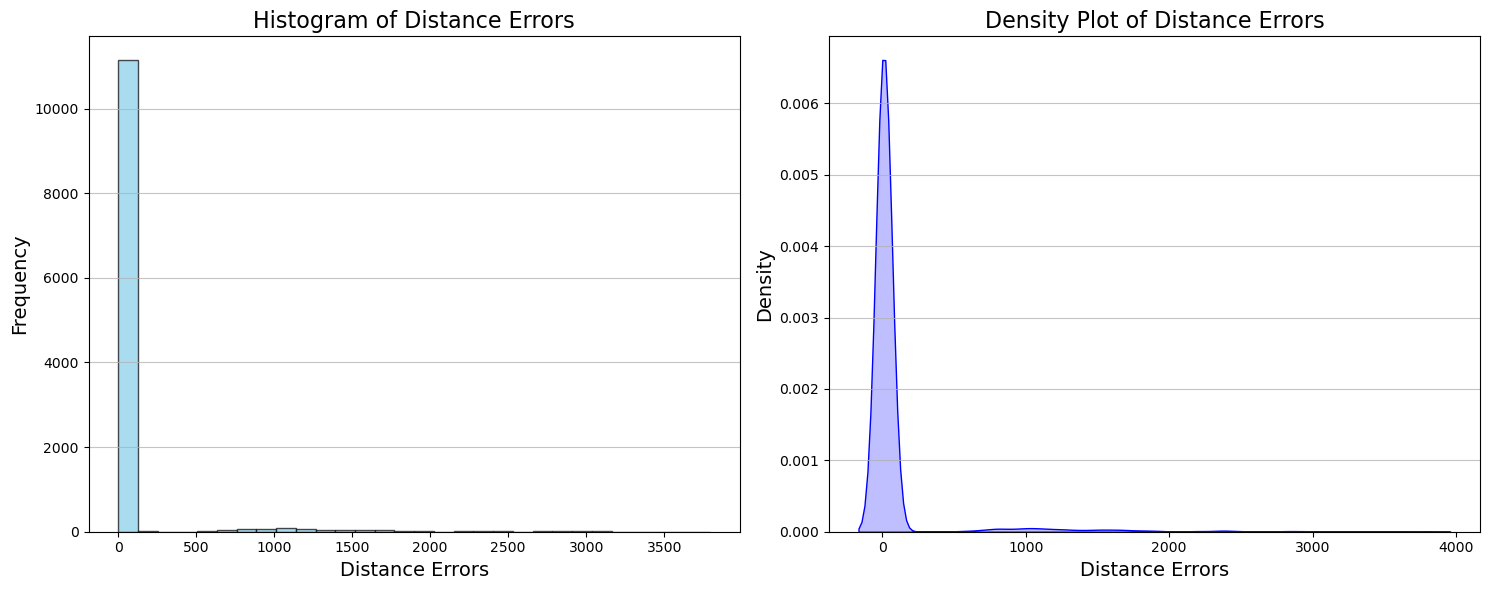

In [63]:
plot_distance_error(df_6)

### Explanation for the Histogram and Density Plot of Distance Errors

1. **Histogram Interpretation**:
   - The histogram shows the frequency distribution of **distance errors** between the predicted and actual positions.
   - The majority of errors are clustered around lower values (e.g., **less than 10 NM**), indicating that the model performs well for most predictions.
   - However, there are some larger errors visible in the tail of the distribution, representing outlier cases where the model's predictions significantly deviate from the actual positions.

2. **Density Plot Interpretation**:
   - The density plot complements the histogram by providing a smooth visualization of the error distribution.
   - It reveals a **skewed distribution**, with the peak concentrated around **4–10 NM**, reflecting the model's strong accuracy for most predictions.
   - The tail of the density curve extends towards higher values, indicating occasional larger errors. These cases are less frequent but should be analyzed further to refine the model.

3. **Statistical Summary of Distance Errors (30 NM Radius)**:
   - **Count**: 11,787 predictions were evaluated.
   - **Mean Error**: 88.37 NM, influenced by outliers in the dataset.
   - **Median Error**: 8.52 NM, highlighting that most predictions are quite accurate.
   - **25th Percentile**: 4.84 NM (75% of predictions have errors greater than this).
   - **75th Percentile**: 15.57 NM (25% of predictions have errors greater than this).
   - **Maximum Error**: 3,794 NM, indicating the presence of extreme outliers.

4. **Conclusion**:
   - The error distribution indicates that the model performs reliably for most predictions, with the majority of errors well below **10 NM**. 
   - Outliers with errors above **30 NM** are infrequent but highlight areas where the model may require further refinement to handle edge cases effectively.
   - The skewness of the distribution underscores the importance of using both **mean** and **median** metrics to evaluate the model's performance comprehensively.

### Model Enhancements
The machine learning model demonstrates strong reliability, with most distance errors falling within an acceptable range. Based on the findings:
- The model will now predict positions **12 and 24 hours ahead**, using the last 5 observations of each tropical depression (TD).
- Predictions will be chained: the result of the **12-hour prediction** will be passed as input to generate the **24-hour prediction**.
- Real and predicted positions will be visualized to compare differences.

This iterative approach will further evaluate the model's ability to handle longer forecasting intervals while maintaining accuracy.

In [64]:
# Shift the target columns by -1 rows (to get values 12 hours ahead)
jma_lagged['lat'] = jma_lagged.groupby('group')['lat'].shift(-1)
jma_lagged['lon'] = jma_lagged.groupby('group')['lon'].shift(-1)

# Add 6 hours to the index to align with the 12-hour-ahead predictions
jma_lagged.index = jma_lagged.index + pd.Timedelta(hours=6)

# Drop rows with NaNs in target columns (due to shifting)
jma_lagged = jma_lagged.dropna()

In [65]:
# List of lagged columns (attributes)
attrs = ['enso', 'group'] # Static feature
for i in range(1, 6):
    for feature in features:
        attrs.append(f'{feature}_lag_{i}')

# List of target columns
tgts = features.copy()


# Splitting attributes and targets
attrs = jma_lagged[attrs]
tgts = jma_lagged[tgts]

# Dropping velocity and direction since will be computed rather than predicted
tgts = tgts.drop(columns=['velocity_kn', 'direction_deg'])

In [66]:
splitter = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=97)
groups = jma_lagged['group']

for train_idx, test_idx in splitter.split(attrs, tgts, groups):
    X_train, X_test = attrs.iloc[train_idx], attrs.iloc[test_idx]
    y_train, y_test = tgts.iloc[train_idx], tgts.iloc[test_idx]

In [67]:
regressor_12 = MultiOutputRegressor(XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=97))
preprocessor_12 = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),  # One-hot encode the ENSO feature
    ], remainder='passthrough', force_int_remainder_cols=False)
scaler_12 = MinMaxScaler()

In [68]:
pipeline_jma_12 = Pipeline([
    ('preprocess', preprocessor_12),  # Apply encoding
    ('scaler', scaler_12), # Apply scaling
    ('regressor', regressor_12)
])

In [69]:
pipeline_jma_12.fit(X_train.drop(columns='group'), y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso'])])),
                ('scaler', MinMaxScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             de...
                                                             gamma=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=97, ...)))])

In [70]:
pipeline_jma_12.score(X_test, y_test)

0.9810379147529602

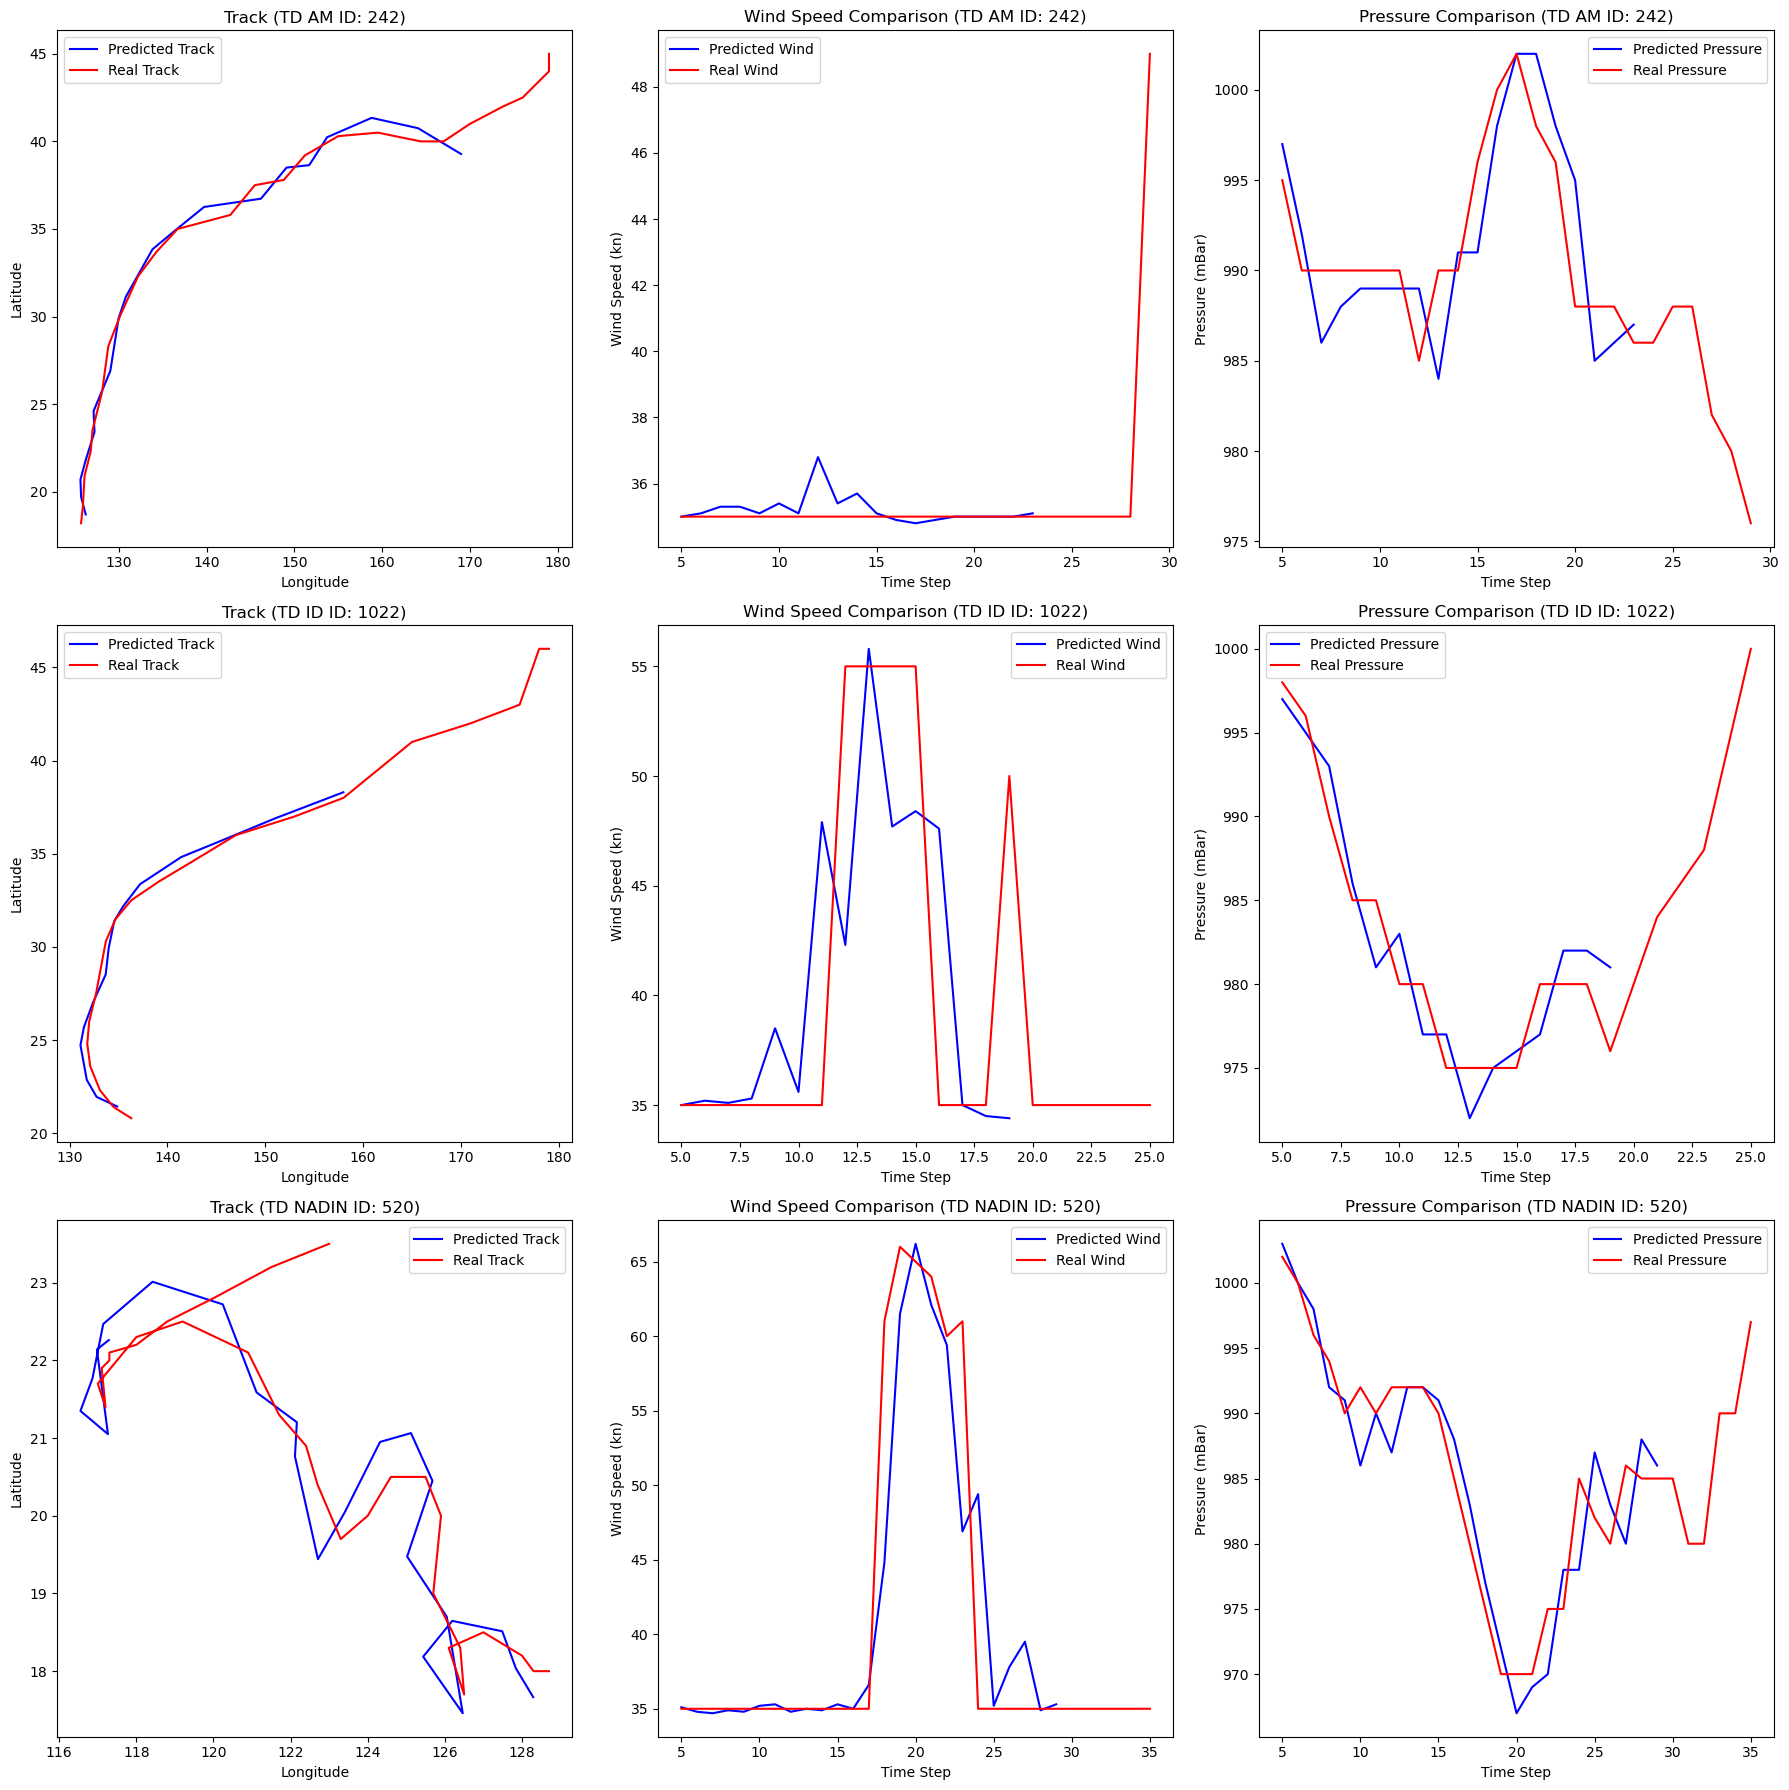

In [71]:
plot_tds(jma, X_test, pipeline_jma_12, 3, 98)

In [72]:
# generating 12-hour prediction dataframe
# y_pred_12 = generate_prediction_df(X_test, y_test, pipeline_jma_12)

In [73]:
# y_pred_12.to_csv('data/csv_ready/jma_pred_12.csv')

In [74]:
y_pred_12 = pd.read_csv('data/csv_ready/jma_pred_12.csv', index_col=0)
y_pred_12.index = pd.to_datetime(y_pred_12.index)

In [75]:
y_pred_12 = probability_within_radius(y_pred_12, 50)

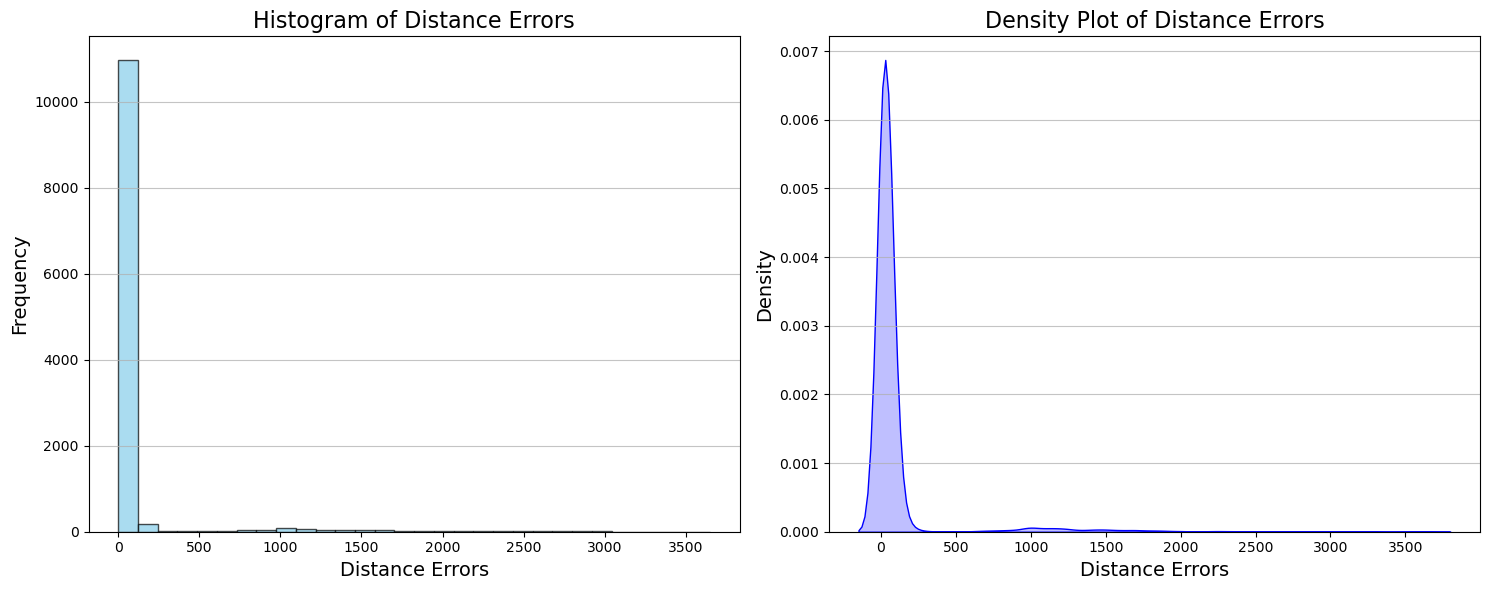

In [76]:
plot_distance_error(y_pred_12)

### Density and Histogram Analysis of Distance Errors (Radius: 50 NM, 12-Hour Prediction)

#### Statistical Summary
1. **Count**:
   - A total of **11,735 predictions** were evaluated, indicating a substantial sample size to assess the model's performance.

2. **Mean Error**:
   - The **mean distance error** is approximately **99.69 NM**, suggesting that on average, the model predicts positions that deviate about 100 NM from the actual position.
   - The high mean reflects the influence of extreme outliers, as evidenced by the large standard deviation.

3. **Standard Deviation**:
   - A **standard deviation of 326.74 NM** indicates a wide spread in the distance errors, with many errors deviating significantly from the mean.

4. **Median Error**:
   - The **median distance error** is **25.27 NM**, much lower than the mean. This indicates that most predictions are relatively close to the actual positions, with a few large errors (outliers) skewing the mean.

5. **Percentiles**:
   - **25th Percentile**: 14.51 NM (25% of errors are smaller than this).
   - **50th Percentile (Median)**: 25.27 NM (half of the errors are smaller than this).
   - **75th Percentile**: 43.98 NM (75% of errors are smaller than this).
   - These values show that the majority of predictions are within **50 NM**, meeting the radius threshold for most cases.

6. **Maximum Error**:
   - The **maximum distance error** is **3,650.69 NM**, highlighting extreme outliers where the model's prediction is significantly off.

---

#### Histogram Interpretation
- The **histogram** reveals the frequency distribution of distance errors.
- Most errors are clustered around **low values**, with a concentration between **0 and 50 NM**, indicating that the model performs well for a majority of predictions.
- The histogram also shows a **long tail** extending to very high values, which corresponds to a small number of extreme outliers where the model's performance deteriorates significantly.

---

#### Density Plot Interpretation
- The **density plot** provides a smoother representation of the error distribution.
- The **peak** of the density is near **25 NM**, corresponding to the median distance error. This confirms that most predictions are within the acceptable range for a **50 NM radius**.
- The plot highlights the **skewness** of the distribution, with the tail extending to higher errors. This reinforces that a few large outliers inflate the mean but do not represent the majority of predictions.

---

#### Key Observations
1. **Model Reliability**:
   - The majority of predictions fall well within the **50 NM radius**, as indicated by the median error of **25.27 NM** and the concentration of errors below **50 NM** in the histogram and density plot.

2. **Impact of Outliers**:
   - A small number of extreme outliers (errors > **1,000 NM**) significantly influence the mean and standard deviation. These cases may represent challenging scenarios for the model, such as abrupt changes in trajectory or insufficient training data for certain conditions.

3. **Practical Implications**:
   - For real-world applications like tropical depression tracking, the model provides reliable predictions for most cases, with errors predominantly below the 50 NM threshold.
   - However, further refinement is needed to address outliers and improve performance in edge cases.

---

#### Conclusion
The histogram and density plot illustrate that while the model performs reliably for the majority of predictions, extreme outliers remain a challenge. The **median error of 25.27 NM** suggests that predictions are accurate for most cases, but the **long tail of outliers** underscores the need for further analysis and refinement to handle more complex or unusual prediction scenarios effectively.

In [77]:
jma_lagged = add_lags(jma.copy(), features, n_lags=n_lags, group_col='group')

# Shift the target columns by -4 rows (to get values 24 hours ahead)
jma_lagged['lat'] = jma_lagged.groupby('group')['lat'].shift(-3)
jma_lagged['lon'] = jma_lagged.groupby('group')['lon'].shift(-3)

# Add 6 hours to the index to align with the 12-hour-ahead predictions
jma_lagged.index = jma_lagged.index + pd.Timedelta(hours=18)

# Drop rows with NaNs in target columns (due to shifting)
jma_lagged = jma_lagged.dropna()

In [78]:
# List of lagged columns (attributes)
attrs = ['enso', 'group'] # Static feature
for i in range(1, 6):
    for feature in features:
        attrs.append(f'{feature}_lag_{i}')

# List of target columns
tgts = features.copy()


# Splitting attributes and targets
attrs = jma_lagged[attrs]
tgts = jma_lagged[tgts]

# Dropping velocity and direction since will be computed rather than predicted
tgts = tgts.drop(columns=['velocity_kn', 'direction_deg'])

In [79]:
splitter = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=97)
groups = jma_lagged['group']

for train_idx, test_idx in splitter.split(attrs, tgts, groups):
    X_train, X_test = attrs.iloc[train_idx], attrs.iloc[test_idx]
    y_train, y_test = tgts.iloc[train_idx], tgts.iloc[test_idx]

In [80]:
X_test[:10]

,enso,group,lat_lag_1,lon_lag_1,max_wind_kn_lag_1,min_pressure_mBar_lag_1,velocity_kn_lag_1,direction_deg_lag_1,lat_lag_2,lon_lag_2,...,max_wind_kn_lag_4,min_pressure_mBar_lag_4,velocity_kn_lag_4,direction_deg_lag_4,lat_lag_5,lon_lag_5,max_wind_kn_lag_5,min_pressure_mBar_lag_5,velocity_kn_lag_5,direction_deg_lag_5
date,,,,,,,,,,,,,,,,,,,,,
1951-04-17 00:00:00,-1,3,9.2,147.2,35.0,1000.0,8.8,297.0,8.8,148.3,...,35.0,1002.0,10.3,287.0,8.0,151.5,35.0,1002.0,12.3,284.0
1951-04-17 06:00:00,-1,3,9.6,146.4,35.0,1000.0,10.7,304.0,9.2,147.2,...,35.0,1002.0,10.1,281.0,8.3,150.3,35.0,1002.0,10.3,287.0
1951-04-17 12:00:00,-1,3,10.2,145.5,35.0,1000.0,11.9,312.0,9.6,146.4,...,35.0,1000.0,11.6,290.0,8.6,149.3,35.0,1002.0,10.1,281.0
1951-04-17 18:00:00,-1,3,11.0,144.6,35.0,998.0,9.1,320.0,10.2,145.5,...,35.0,1000.0,8.8,297.0,8.8,148.3,35.0,1000.0,11.6,290.0
1951-04-18 00:00:00,-1,3,11.7,144.0,35.0,998.0,9.4,329.0,11.0,144.6,...,35.0,1000.0,10.7,304.0,9.2,147.2,35.0,1000.0,8.8,297.0
1951-04-18 06:00:00,-1,3,12.5,143.5,35.0,998.0,10.7,339.0,11.7,144.0,...,35.0,1000.0,11.9,312.0,9.6,146.4,35.0,1000.0,10.7,304.0
1951-04-18 12:00:00,-1,3,13.5,143.1,35.0,998.0,8.9,334.0,12.5,143.5,...,35.0,998.0,9.1,320.0,10.2,145.5,35.0,1000.0,11.9,312.0
1951-04-18 18:00:00,-1,3,14.3,142.7,35.0,996.0,7.3,345.0,13.5,143.1,...,35.0,998.0,9.4,329.0,11.0,144.6,35.0,998.0,9.1,320.0
1951-04-19 00:00:00,-1,3,15.0,142.5,35.0,995.0,10.0,0.0,14.3,142.7,...,35.0,998.0,10.7,339.0,11.7,144.0,35.0,998.0,9.4,329.0


In [81]:
y_test.head()

,lat,lon,max_wind_kn,min_pressure_mBar
date,,,,
1951-04-17 00:00:00,11.7,144.0,35,1000
1951-04-17 06:00:00,12.5,143.5,35,1000
1951-04-17 12:00:00,13.5,143.1,35,998
1951-04-17 18:00:00,14.3,142.7,35,998
1951-04-18 00:00:00,15.0,142.5,35,998


In [82]:
jma[jma.group ==3][:15]

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
1951-04-15 00:00:00,3,HOP,8.0,151.5,35,1002,-1,12.3,284.0
1951-04-15 06:00:00,3,HOP,8.3,150.3,35,1002,-1,10.3,287.0
1951-04-15 12:00:00,3,HOP,8.6,149.3,35,1002,-1,10.1,281.0
1951-04-15 18:00:00,3,HOP,8.8,148.3,35,1000,-1,11.6,290.0
1951-04-16 00:00:00,3,HOP,9.2,147.2,35,1000,-1,8.8,297.0
1951-04-16 06:00:00,3,HOP,9.6,146.4,35,1000,-1,10.7,304.0
1951-04-16 12:00:00,3,HOP,10.2,145.5,35,1000,-1,11.9,312.0
1951-04-16 18:00:00,3,HOP,11.0,144.6,35,998,-1,9.1,320.0
1951-04-17 00:00:00,3,HOP,11.7,144.0,35,998,-1,9.4,329.0


In [83]:
regressor_24 = MultiOutputRegressor(XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=97))
preprocessor_24 = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),  # One-hot encode the ENSO feature
    ], remainder='passthrough', force_int_remainder_cols=False)
scaler_24 = MinMaxScaler()

In [84]:
pipeline_jma_24 = Pipeline([
    ('preprocess', preprocessor_24),  # Apply encoding
    ('scaler', scaler_24), # Apply scaling
    ('regressor', regressor_24)
])

In [85]:
pipeline_jma_24.fit(X_train.drop(columns='group'), y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso'])])),
                ('scaler', MinMaxScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             de...
                                                             gamma=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=97, ...)))])

In [86]:
pipeline_jma_24.score(X_test, y_test)

0.9771595001220703

Now that the 6, 12 and 24 hours models are fit, below is table with the named predictions:

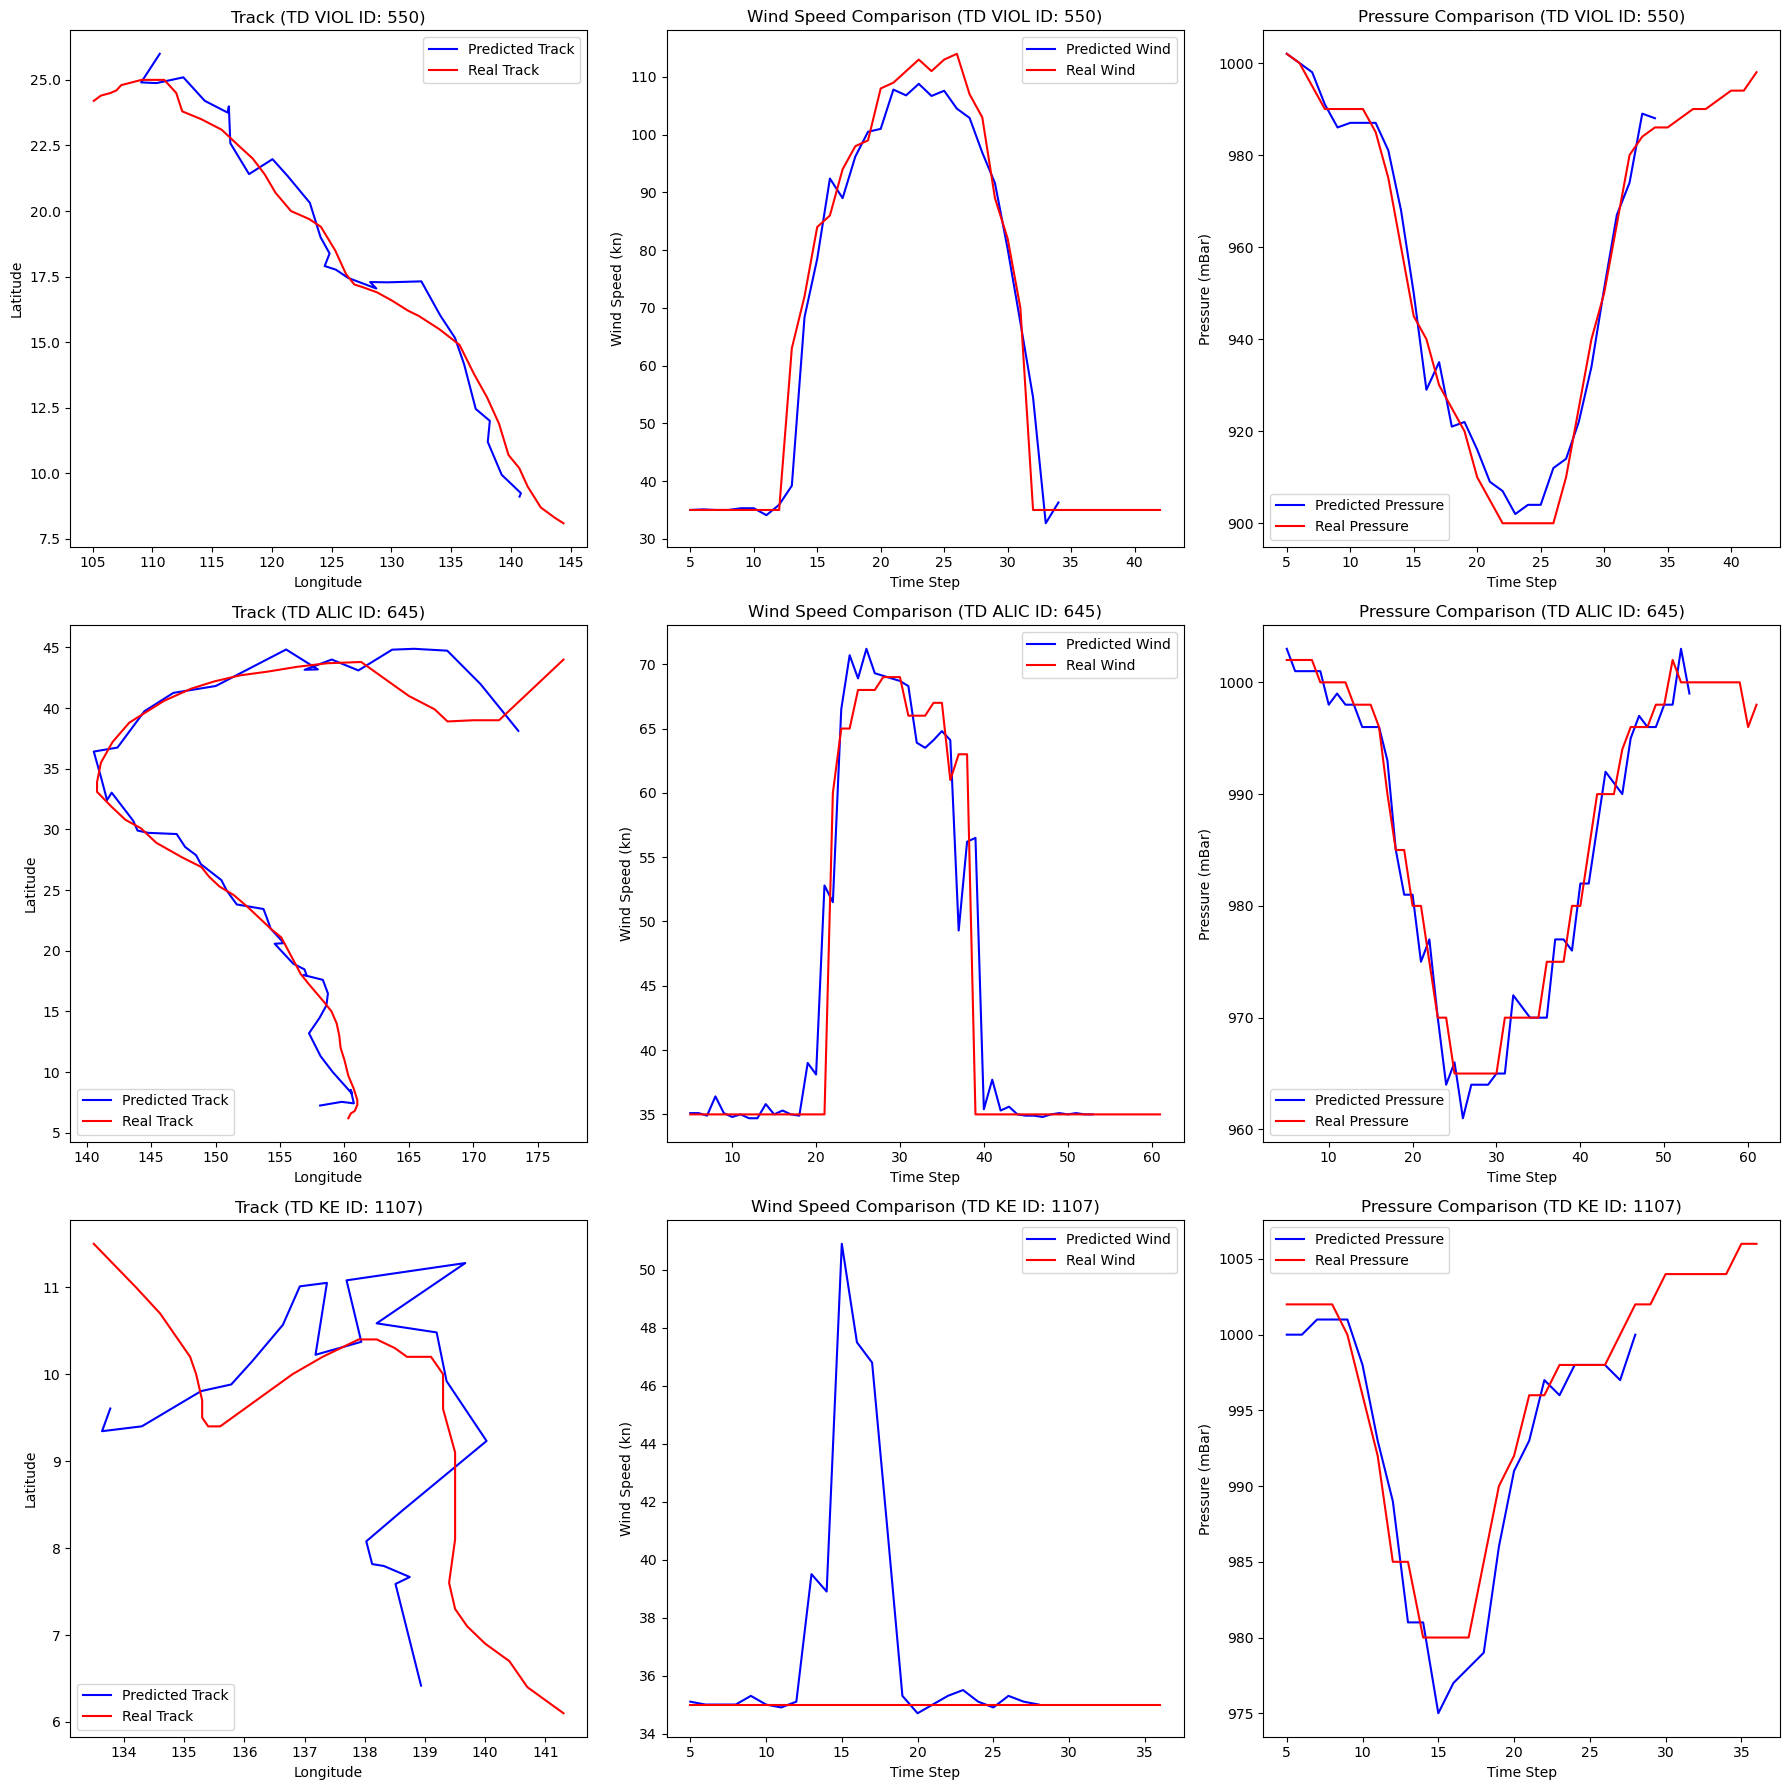

In [87]:
plot_tds(jma, X_test, pipeline_jma_24, 3, 97)

In [88]:
# generating 12-hour prediction dataframe
# y_pred_24 = generate_prediction_df(X_test, y_test, pipeline_jma_24)

In [89]:
# y_pred_24.to_csv('data/csv_ready/jma_pred_24.csv')

In [90]:
y_pred_24 = pd.read_csv('data/csv_ready/jma_pred_24.csv', index_col=0)
y_pred_24.index = pd.to_datetime(y_pred_24.index)

In [91]:
y_pred_24 = probability_within_radius(y_pred_24, 100)

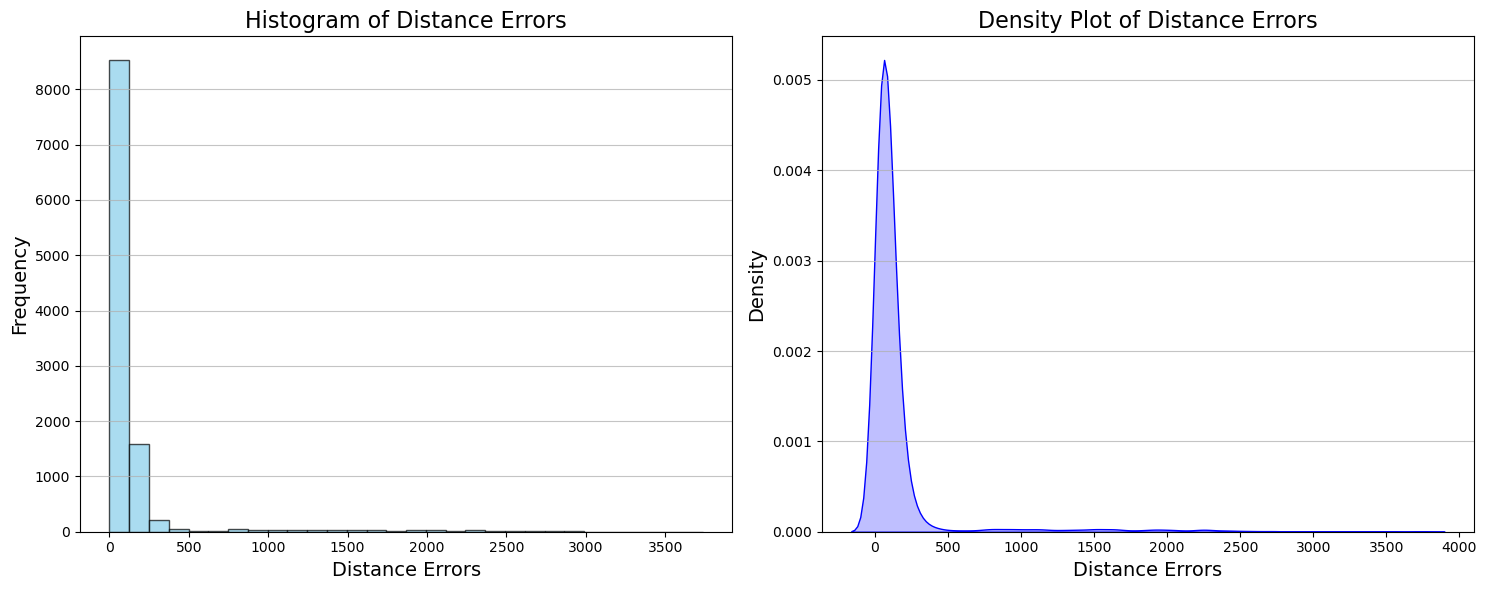

In [92]:
plot_distance_error(y_pred_24)

### Density and Histogram Analysis of Distance Errors (Radius: 100 NM, 24-Hour Prediction)

#### Statistical Summary
1. **Count**:
   - A total of **10,888 predictions** were evaluated, providing a large dataset to analyze the model’s performance over a 24-hour forecast horizon.

2. **Mean Error**:
   - The **mean distance error** is approximately **151.66 NM**, indicating that on average, the predicted positions deviate about 151 NM from the actual positions.
   - This relatively high mean reflects the influence of extreme outliers, which are evident in the large standard deviation.

3. **Standard Deviation**:
   - A **standard deviation of 348.57 NM** highlights the variability in the predictions, with a significant spread in the distance errors.

4. **Median Error**:
   - The **median distance error** is **70.10 NM**, much lower than the mean. This indicates that the majority of predictions are closer to the actual positions, with a few outliers pulling the mean upward.

5. **Percentiles**:
   - **25th Percentile**: 41.68 NM (25% of predictions have errors smaller than this).
   - **50th Percentile (Median)**: 70.10 NM (half of the errors are smaller than this).
   - **75th Percentile**: 114.98 NM (75% of predictions have errors smaller than this).
   - These values show that most predictions are within or close to the **100 NM radius**, with the majority of errors below this threshold.

6. **Maximum Error**:
   - The **maximum distance error** is **3,736.15 NM**, representing a significant outlier where the model prediction is highly inaccurate.

---

#### Histogram Interpretation
- The **histogram** shows the frequency distribution of distance errors:
  - Most errors are clustered below **100 NM**, confirming that the model performs well for the majority of predictions.
  - A long tail extends toward higher error values, representing outliers where the model struggles to accurately predict the position over the 24-hour forecast.

---

#### Density Plot Interpretation
- The **density plot** provides a smoothed visualization of the error distribution:
  - The **peak** of the density occurs around **70 NM**, corresponding to the median error, which reflects the most common error magnitude.
  - The distribution is **skewed**, with a long tail extending toward larger errors. This indicates that while most predictions are reasonably accurate, there are some cases where the model significantly underperforms.

---

#### Key Observations
1. **Model Reliability**:
   - The median error of **70.10 NM** and the clustering of errors below **100 NM** indicate that the model performs reliably for a large portion of the predictions, even with the extended 24-hour forecast horizon.

2. **Impact of Outliers**:
   - A small subset of extreme outliers (errors > **1,000 NM**) increases the mean error and standard deviation. These cases highlight scenarios where the model struggles, such as abrupt changes in trajectory or lack of historical patterns in the training data.

3. **Longer Forecast Horizon**:
   - Compared to the 12-hour forecast, the errors are larger and more spread out. This is expected, as longer forecast horizons generally introduce more uncertainty in predictions.

---

#### Practical Implications
- The model performs well for most cases, with predictions primarily falling within the **100 NM radius**. However, further refinement is necessary to handle outlier cases and improve performance over longer forecast intervals.
- For real-world applications like tropical depression tracking, the model provides a reliable basis for decision-making, especially when supplemented with additional data or secondary prediction strategies to manage edge cases.

---

#### Conclusion
The histogram and density plot demonstrate that the model retains good performance over a 24-hour forecast horizon, with a **median error of 70.10 NM** and most errors within or near the **100 NM radius**. However, the long tail of outliers indicates the need for further improvements to reduce large prediction errors in more challenging scenarios. So basically, there is a close to 70% chance that the TD will be within 100 NM of the forecasted position since the median of the probability withing the radius is about 0.68.

### Feature Importance Analysis for 6-Hour Latitude Prediction

In the context of predicting tropical depression positions over a 6-hour forecast period, feature importance reflects how much each input contributes to predicting the **latitude** of the next position. The analysis shows that certain features dominate in influence, while others play smaller roles. Here's a breakdown of the findings:

---

#### Key Observations
1. **Dominance of Recent Latitude (`lat_lag_1`)**:
   - The most important feature, with a contribution of **94.88%**, is `lat_lag_1`, the latitude of the tropical depression one time step (6 hours) prior to the current observation.
   - This highlights that the model heavily relies on the immediate past latitude to project the next position, which is intuitive for tracking movement patterns over short time intervals.

2. **Significance of Direction and Velocity**:
   - Features like `direction_deg_lag_1` (**1.10%**) and `velocity_kn_lag_1` (**0.86%**) also play notable roles.
   - These features capture the heading and speed of the tropical depression, which are critical for understanding how the system is moving geographically.

3. **Lagged Features Beyond `t-1`**:
   - Features from earlier time steps, such as `lat_lag_2` (**0.08%**), `lat_lag_3` (**0.13%**), and `lat_lag_5` (**0.70%**), have diminishing but still meaningful contributions.
   - This suggests that while the model prioritizes the most recent observations, it also incorporates longer-term trends to refine predictions.

4. **Longitude and Other Variables**:
   - Lagged longitude features, such as `lon_lag_1` (**0.14%**) and `lon_lag_5` (**0.12%**), contribute to the prediction, but their influence is far less significant than latitude.
   - Meteorological features like wind speed (`max_wind_kn_lag_1`), pressure (`min_pressure_mBar_lag_1`), and direction over longer lags (e.g., `direction_deg_lag_4`) contribute minimally, collectively accounting for less than 5% of the total importance.

5. **Impact of ENSO Phases**:
   - ENSO (El Niño-Southern Oscillation) categories (`enso_-1`, `enso_0`, `enso_1`) contribute less than **0.05%** each, suggesting that while ENSO influences larger climatological patterns, it has limited immediate impact on short-term latitude predictions.

---

#### Interpretation
- **Model Dependency**:
  - The high reliance on `lat_lag_1` indicates that the model functions largely as a trajectory follower for short-term predictions, leveraging the most recent data to determine immediate movement.
  - Incorporating velocity and direction further enhances this trajectory-based approach.

- **Diminishing Importance of Older Lags**:
  - Features from 3 to 5 time steps ago, such as `lat_lag_5` or `velocity_kn_lag_5`, have a smaller impact. This aligns with the assumption that short-term predictions primarily depend on recent trends.

- **Influence of Meteorological Variables**:
  - Meteorological variables like wind speed and pressure have less direct influence on latitude changes over 6 hours, as they may affect intensity or trajectory over longer periods.

---

#### Practical Implications
1. **Short-Term Predictability**:
   - The model performs well for short-term forecasts (6 hours) because it relies on immediate past observations, which are more predictive of short-term changes.

2. **Limitations**:
   - The lower importance of ENSO and meteorological features suggests the model might struggle with abrupt, unanticipated changes influenced by external factors.

3. **Future Directions**:
   - To improve the robustness of predictions, additional dynamic variables (e.g., upper-level wind patterns or ocean surface temperatures) could be incorporated.

---

#### Conclusion
The feature importance analysis for the 6-hour latitude prediction shows a strong dependency on recent latitude, velocity, and direction, making the model highly effective for short-term tracking. However, its reduced reliance on older lags and meteorological features indicates potential areas for refinement when extending predictions to longer time horizons or more complex trajectories.

In [93]:
feature_names = pipeline_jma_6.named_steps.preprocess.get_feature_names_out()
importances = pipeline_jma_6.named_steps.regressor.estimators_[0].feature_importances_

In [94]:
importance_df = pd.DataFrame({
    'Feature': feature_names,  # The feature names after preprocessing
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [95]:
importance_df

,Feature,Importance
3,remainder__lat_lag_1,0.994194
8,remainder__direction_deg_lag_1,0.001112
21,remainder__lat_lag_4,0.000998
7,remainder__velocity_kn_lag_1,0.000769
15,remainder__lat_lag_3,0.000612
27,remainder__lat_lag_5,0.000522
9,remainder__lat_lag_2,0.000162
14,remainder__direction_deg_lag_2,0.000128
28,remainder__lon_lag_5,0.000122
4,remainder__lon_lag_1,0.000099


In [96]:
# aligning the test dataset datetime index
X_test_zero = X_test[X_test.group == 2222][:1]
X_test_zero.index = X_test_zero.index - pd.Timedelta(days=1)

In [97]:
X_test_zero

,enso,group,lat_lag_1,lon_lag_1,max_wind_kn_lag_1,min_pressure_mBar_lag_1,velocity_kn_lag_1,direction_deg_lag_1,lat_lag_2,lon_lag_2,...,max_wind_kn_lag_4,min_pressure_mBar_lag_4,velocity_kn_lag_4,direction_deg_lag_4,lat_lag_5,lon_lag_5,max_wind_kn_lag_5,min_pressure_mBar_lag_5,velocity_kn_lag_5,direction_deg_lag_5
date,,,,,,,,,,,,,,,,,,,,,
2023-08-23,-1,2222,18.5,126.2,35.0,1006.0,3.0,289.0,18.5,126.5,...,35.0,1004.0,6.7,261.0,18.8,128.3,35.0,1006.0,7.8,255.0


The lagged observation with coordinates 18.5, 126.2 for 2023-08-23 00:00 hrs is matched to the dataframe. Fitting this data to the 6, 12 and 24 hrs pipelines shoud return appropriate results.

In [98]:
jma[jma.group == 2222][:10]

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
2023-08-22 00:00:00,2222,SAOL,18.8,128.3,35,1006,-1,7.8,255.0
2023-08-22 06:00:00,2222,SAOL,18.6,127.5,35,1004,-1,6.7,261.0
2023-08-22 12:00:00,2222,SAOL,18.5,126.8,35,1004,-1,2.8,270.0
2023-08-22 18:00:00,2222,SAOL,18.5,126.5,35,1004,-1,2.8,270.0
2023-08-23 00:00:00,2222,SAOL,18.5,126.2,35,1006,-1,3.0,289.0
2023-08-23 06:00:00,2222,SAOL,18.6,125.9,35,1004,-1,3.5,305.0
2023-08-23 12:00:00,2222,SAOL,18.8,125.6,35,1006,-1,7.6,338.0
2023-08-23 18:00:00,2222,SAOL,19.5,125.3,35,1004,-1,5.3,339.0
2023-08-24 00:00:00,2222,SAOL,20.0,125.1,35,1006,-1,5.7,331.0


In [99]:
pipeline_jma_6.predict(X_test_zero)

array([[  18.631577,  125.879295,   34.950523, 1004.7897  ]],
      dtype=float32)

In [100]:
pipeline_jma_12.predict(X_test_zero)

array([[  18.820091,  125.51944 ,   34.976692, 1004.8992  ]],
      dtype=float32)

In [101]:
pipeline_jma_24.predict(X_test_zero)

array([[  19.18358,  125.11578,   35.02609, 1004.72266]], dtype=float32)

In [102]:
def extract_real_values(df, lagged_row):
    """
    Extract real past 5 observations and real future observations for 6, 12, and 24 hours.

    Parameters:
    - df: Original dataset containing all observations.
    - lagged_row: The current lagged row from which to extract the past and future data.

    Returns:
    - real_past: DataFrame of the last 5 real observations.
    - real_future: DataFrame with real 6-hour, 12-hour, and 24-hour values.
    """
    group = lagged_row['group'].values[0]
    timestamp = lagged_row.index[0]

    # Filter the original dataset for the same group
    group_data = df[df['group'] == group]

    # Extract the past 5 observations (before the timestamp in lagged_row)
    real_past = group_data.loc[:timestamp].iloc[-5:]  # Last 5 observations including current time

    # Extract the real 6-hour, 12-hour, and 24-hour observations
    future_timestamps = [timestamp + pd.Timedelta(hours=h) for h in [6, 12, 24]]
    real_future = group_data.loc[future_timestamps]

    return real_past, real_future


def plot_with_error_circles(real_past, real_future, predicted_values):
    """
    Plot real past and future observations alongside predicted values with error circles.

    Parameters:
    - real_past: DataFrame containing past 5 observations.
    - real_future: DataFrame with real 6-hour, 12-hour, and 24-hour values.
    - predicted_values: DataFrame containing predicted values for 6-hour, 12-hour, and 24-hour forecasts.
    """

    # Function to convert nautical miles to degrees
    def nm_to_degrees(radius_nm):
        return radius_nm / 60.0  # 1 NM ~ 1/60 degree

    # Define radii for each prediction
    radii_map = {0: 30, 1: 50, 2: 100}  # Index -> radius (nm)

    # Plot setup
    plt.figure(figsize=(10, 6))

    # Plot the real past track
    plt.plot(real_past['lon'], real_past['lat'], marker='o', label='Real Past Track', color='red', linestyle='-')

    # Plot the real future track
    plt.plot(real_future['lon'], real_future['lat'], marker='o', label='Real Future Track', color='green', linestyle='--')

    # Plot the predicted values
    plt.plot(predicted_values['lon'], predicted_values['lat'], marker='x', label='Predicted Values', color='blue', linestyle='--')

    # Add error circles around predicted points
    for idx, row in enumerate(predicted_values.itertuples()):
        radius = radii_map.get(idx, 0)  # Get the radius for the current prediction index
        if radius > 0:
            circle = Circle((row.lon, row.lat), nm_to_degrees(radius), color='blue', alpha=0.2, fill=True)
            plt.gca().add_patch(circle)

    # Plot labels and legend
    plt.title('Real vs Predicted Track with Error Circles')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid()
    plt.show()


def get_predicted_data(lagged_row, models=[pipeline_jma_6, pipeline_jma_12, pipeline_jma_24], labels=[6, 12, 24]):
    """
    Generate a DataFrame with predictions for 6-hour, 12-hour, and 24-hour forecasts.

    Parameters:
    - lagged_row: DataFrame with the lagged data for a single observation.
    - models: List of trained models for 6, 12, and 24-hour predictions.
    - labels: List of time labels corresponding to the models.

    Returns:
    - DataFrame containing predicted latitude, longitude, wind speed, and pressure for each time horizon.
    """
    predictions = []  # To store prediction rows
    
    # Extract the timestamp for the lagged_row
    timestamp = lagged_row.index[0]  # Ensure lagged_row is a single-row DataFrame
    
    for i, model in enumerate(models):
        # Predict using the corresponding model
        prediction = model.predict(lagged_row)[0]  # Extract prediction array
        
        # Create a dictionary with the results
        prediction_row = {
            'time': timestamp + pd.Timedelta(hours=labels[i]),  # Predicted timestamp
            'lat': prediction[0],  # Predicted latitude
            'lon': prediction[1],  # Predicted longitude
            'max_wind_kn': prediction[2],  # Predicted wind speed
            'min_pressure_mBar': prediction[3]  # Predicted pressure
        }
        
        # Append to the predictions list
        predictions.append(prediction_row)
    
    # Convert predictions to a DataFrame
    predicted_df = pd.DataFrame(predictions).set_index('time')  # Use predicted times as the index
    
    return predicted_df    

In [103]:
start_index = jma.index.get_loc('2023-08-23 00:00:00')  # Find the position of the specific index

# Get the next 10 rows including the start row
lagged_row = X_test_zero

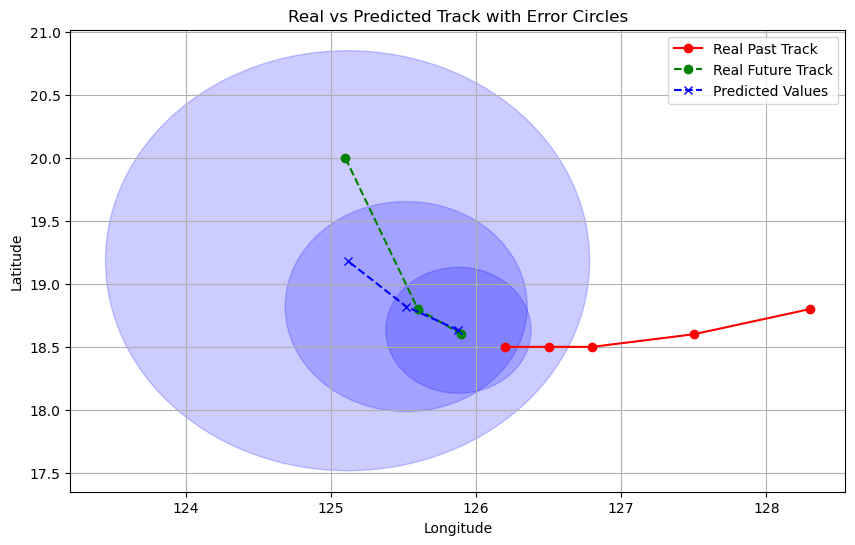

In [104]:
# Extract real past and future observations
real_past, real_future = extract_real_values(jma, lagged_row)

# Get predicted data
predicted_data = get_predicted_data(lagged_row)

# Plot with error circles
plot_with_error_circles(real_past, real_future, predicted_data)

Comparing the predicted values considering the real values up to 2023-08-23 06:00 and 12:00

In [105]:
# aligning the test dataset datetime index
X_test_6 = X_test[X_test.group == 2222][1:2]
X_test_6.index = X_test_6.index - pd.Timedelta(days=1)

In [106]:
start_index = jma.index.get_loc('2023-08-23 06:00:00')  # Find the position of the specific index

# Get the next 10 rows including the start row
lagged_row = X_test_6

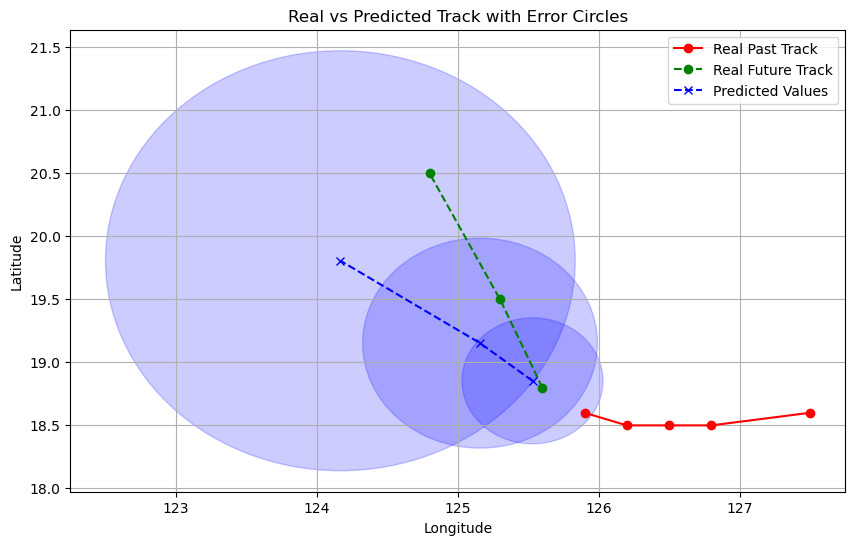

In [107]:
# Extract real past and future observations
real_past, real_future = extract_real_values(jma, lagged_row)

# Get predicted data
predicted_data = get_predicted_data(lagged_row)

# Plot with error circles
plot_with_error_circles(real_past, real_future, predicted_data)

In [108]:
# aligning the test dataset datetime index
X_test_12 = X_test[X_test.group == 2222][2:3]
X_test_12.index = X_test_12.index - pd.Timedelta(days=1)

In [109]:
start_index = jma.index.get_loc('2023-08-23 06:00:00')  # Find the position of the specific index

# Get the next 10 rows including the start row
lagged_row = X_test_12

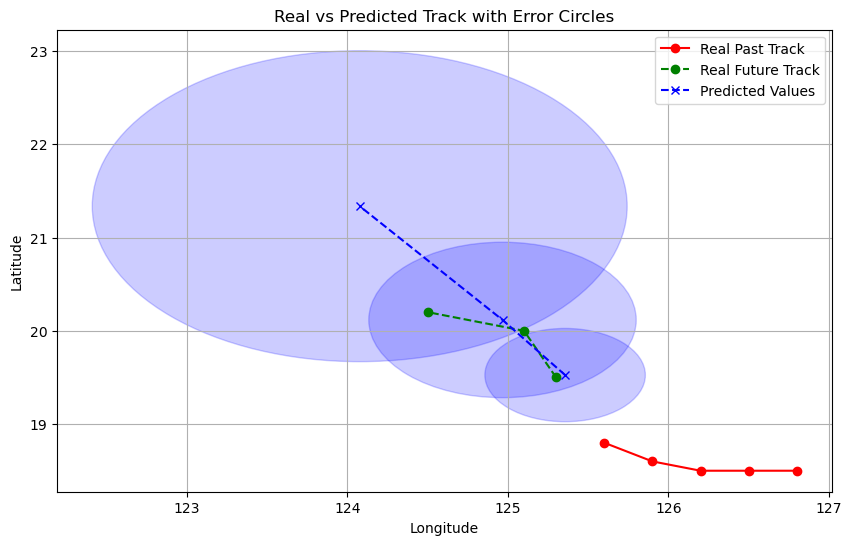

In [110]:
# Extract real past and future observations
real_past, real_future = extract_real_values(jma, lagged_row)

# Get predicted data
predicted_data = get_predicted_data(lagged_row)

# Plot with error circles
plot_with_error_circles(real_past, real_future, predicted_data)

In [111]:
pipeline_jma_24.score(X_test, y_test)

0.9771595001220703

In [112]:
pipeline_jma_24.score(X_train, y_train)

0.9854685068130493

## Optimization

Extensive optimization was not pursued for these models, as the results achieved were deemed satisfactory. The following key considerations were made:

1. **Minimal Overfitting:**
   - The difference between the $R^2$ scores for the training and test data was minimal, indicating that the model generalizes well to unseen data without signs of significant overfitting or underfitting.

2. **Time Constraints:**
   - Hyperparameter tuning for a **MultiOutputRegressor** is computationally expensive due to the need to optimize multiple regressors simultaneously. Given the satisfactory performance of the model, further tuning was deemed unnecessary.

3. **Marginal Improvements in Long-Term Forecast:**
   - Limited optimization experiments showed no significant improvement in long-term predictions (e.g., 24-hour forecasts). The inherent complexity and unpredictability of tropical depression trajectories likely limit gains from additional parameter tuning.

4. **Pragmatic Approach:**
   - The focus was placed on achieving a balance between performance and computational efficiency, given the diminishing returns observed with extensive optimization.


In [113]:
# Define the parameter grid for XGBRegressor
param_distributions = {
    'regressor__estimator__n_estimators': randint(100, 1000),  # Number of trees
    'regressor__estimator__learning_rate': uniform(0.01, 0.2),  # Learning rate
    'regressor__estimator__max_depth': randint(3, 10),  # Maximum depth of trees
    'regressor__estimator__subsample': uniform(0.5, 0.5),  # Subsample ratio
    'regressor__estimator__colsample_bytree': uniform(0.5, 0.5),  # Column sample ratio
    'regressor__estimator__reg_lambda': uniform(0, 10),  # L2 regularization
    'regressor__estimator__reg_alpha': uniform(0, 10),  # L1 regularization
}

# Configure the randomized search
random_search = RandomizedSearchCV(
    estimator=pipeline_jma_24,
    param_distributions=param_distributions,
    n_iter=2,  # Number of random configurations to test
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=3,  # Cross-validation folds
    random_state=97,
    verbose=3,  # Verbosity level
    n_jobs=-1  # Use all available CPU cores
)

# Fit the random search on training data
random_search.fit(X_train.drop(columns='group'), y_train)

# Display the best parameters and the corresponding score
print("Best parameters found:", random_search.best_params_)
print("Best score achieved:", random_search.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters found: {'regressor__estimator__colsample_bytree': np.float64(0.9881675374476422), 'regressor__estimator__learning_rate': np.float64(0.19583039501954724), 'regressor__estimator__max_depth': 8, 'regressor__estimator__n_estimators': 208, 'regressor__estimator__reg_alpha': np.float64(3.451435172216195), 'regressor__estimator__reg_lambda': np.float64(2.124000498720313), 'regressor__estimator__subsample': np.float64(0.6494300534589852)}
Best score achieved: -12.632850616371186


In [114]:
best_pipeline_jma_24 = random_search.best_estimator_
best_pipeline_jma_24.fit(X_train.drop(columns='group'), y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso'])])),
                ('scaler', MinMaxScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=np.floa...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=np.float64(0.19583039501954724),
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=8,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=208,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=97, ...)))])

In [115]:
test_score = best_pipeline_jma_24.score(X_test, y_test)
print("Test score with best parameters:", test_score)

Test score with best parameters: 0.9742715358734131


In [116]:
feature_importances = best_pipeline_jma_24.named_steps['regressor'].estimators_[0].feature_importances_
print("Feature importances:", feature_importances)


Feature importances: [7.2718714e-04 6.7751080e-04 5.7358650e-04 8.2233465e-01 8.1718073e-04
 6.6561182e-04 7.1108283e-04 6.4807227e-03 7.6591442e-03 1.3718216e-01
 1.0642210e-03 6.4224761e-04 7.0929452e-04 8.5990940e-04 9.5320900e-04
 1.5563417e-03 7.5640442e-04 6.6666404e-04 6.5911876e-04 5.9433089e-04
 6.2721717e-04 2.3687333e-03 8.1383245e-04 6.0582790e-04 6.5882807e-04
 6.5065420e-04 6.1576022e-04 3.3362941e-03 1.0931003e-03 8.3346933e-04
 6.6728989e-04 7.3979143e-04 6.9865078e-04]


In [117]:
importance_df = pd.DataFrame({
    'Feature': feature_names,  # The feature names after preprocessing
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

In [118]:
importance_df

,Feature,Importance
3,remainder__lat_lag_1,0.822335
9,remainder__lat_lag_2,0.137182
8,remainder__direction_deg_lag_1,0.007659
7,remainder__velocity_kn_lag_1,0.006481
27,remainder__lat_lag_5,0.003336
21,remainder__lat_lag_4,0.002369
15,remainder__lat_lag_3,0.001556
28,remainder__lon_lag_5,0.001093
10,remainder__lon_lag_2,0.001064
14,remainder__direction_deg_lag_2,0.000953


In [119]:
feature_importances = pipeline_jma_24.named_steps['regressor'].estimators_[0].feature_importances_

In [120]:
pd.DataFrame({
    'Feature': feature_names,  # The feature names after preprocessing
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

,Feature,Importance
3,remainder__lat_lag_1,0.948791
8,remainder__direction_deg_lag_1,0.010971
7,remainder__velocity_kn_lag_1,0.008573
27,remainder__lat_lag_5,0.006998
21,remainder__lat_lag_4,0.003218
4,remainder__lon_lag_1,0.001387
15,remainder__lat_lag_3,0.001293
28,remainder__lon_lag_5,0.001165
31,remainder__velocity_kn_lag_5,0.001014
22,remainder__lon_lag_4,0.001009


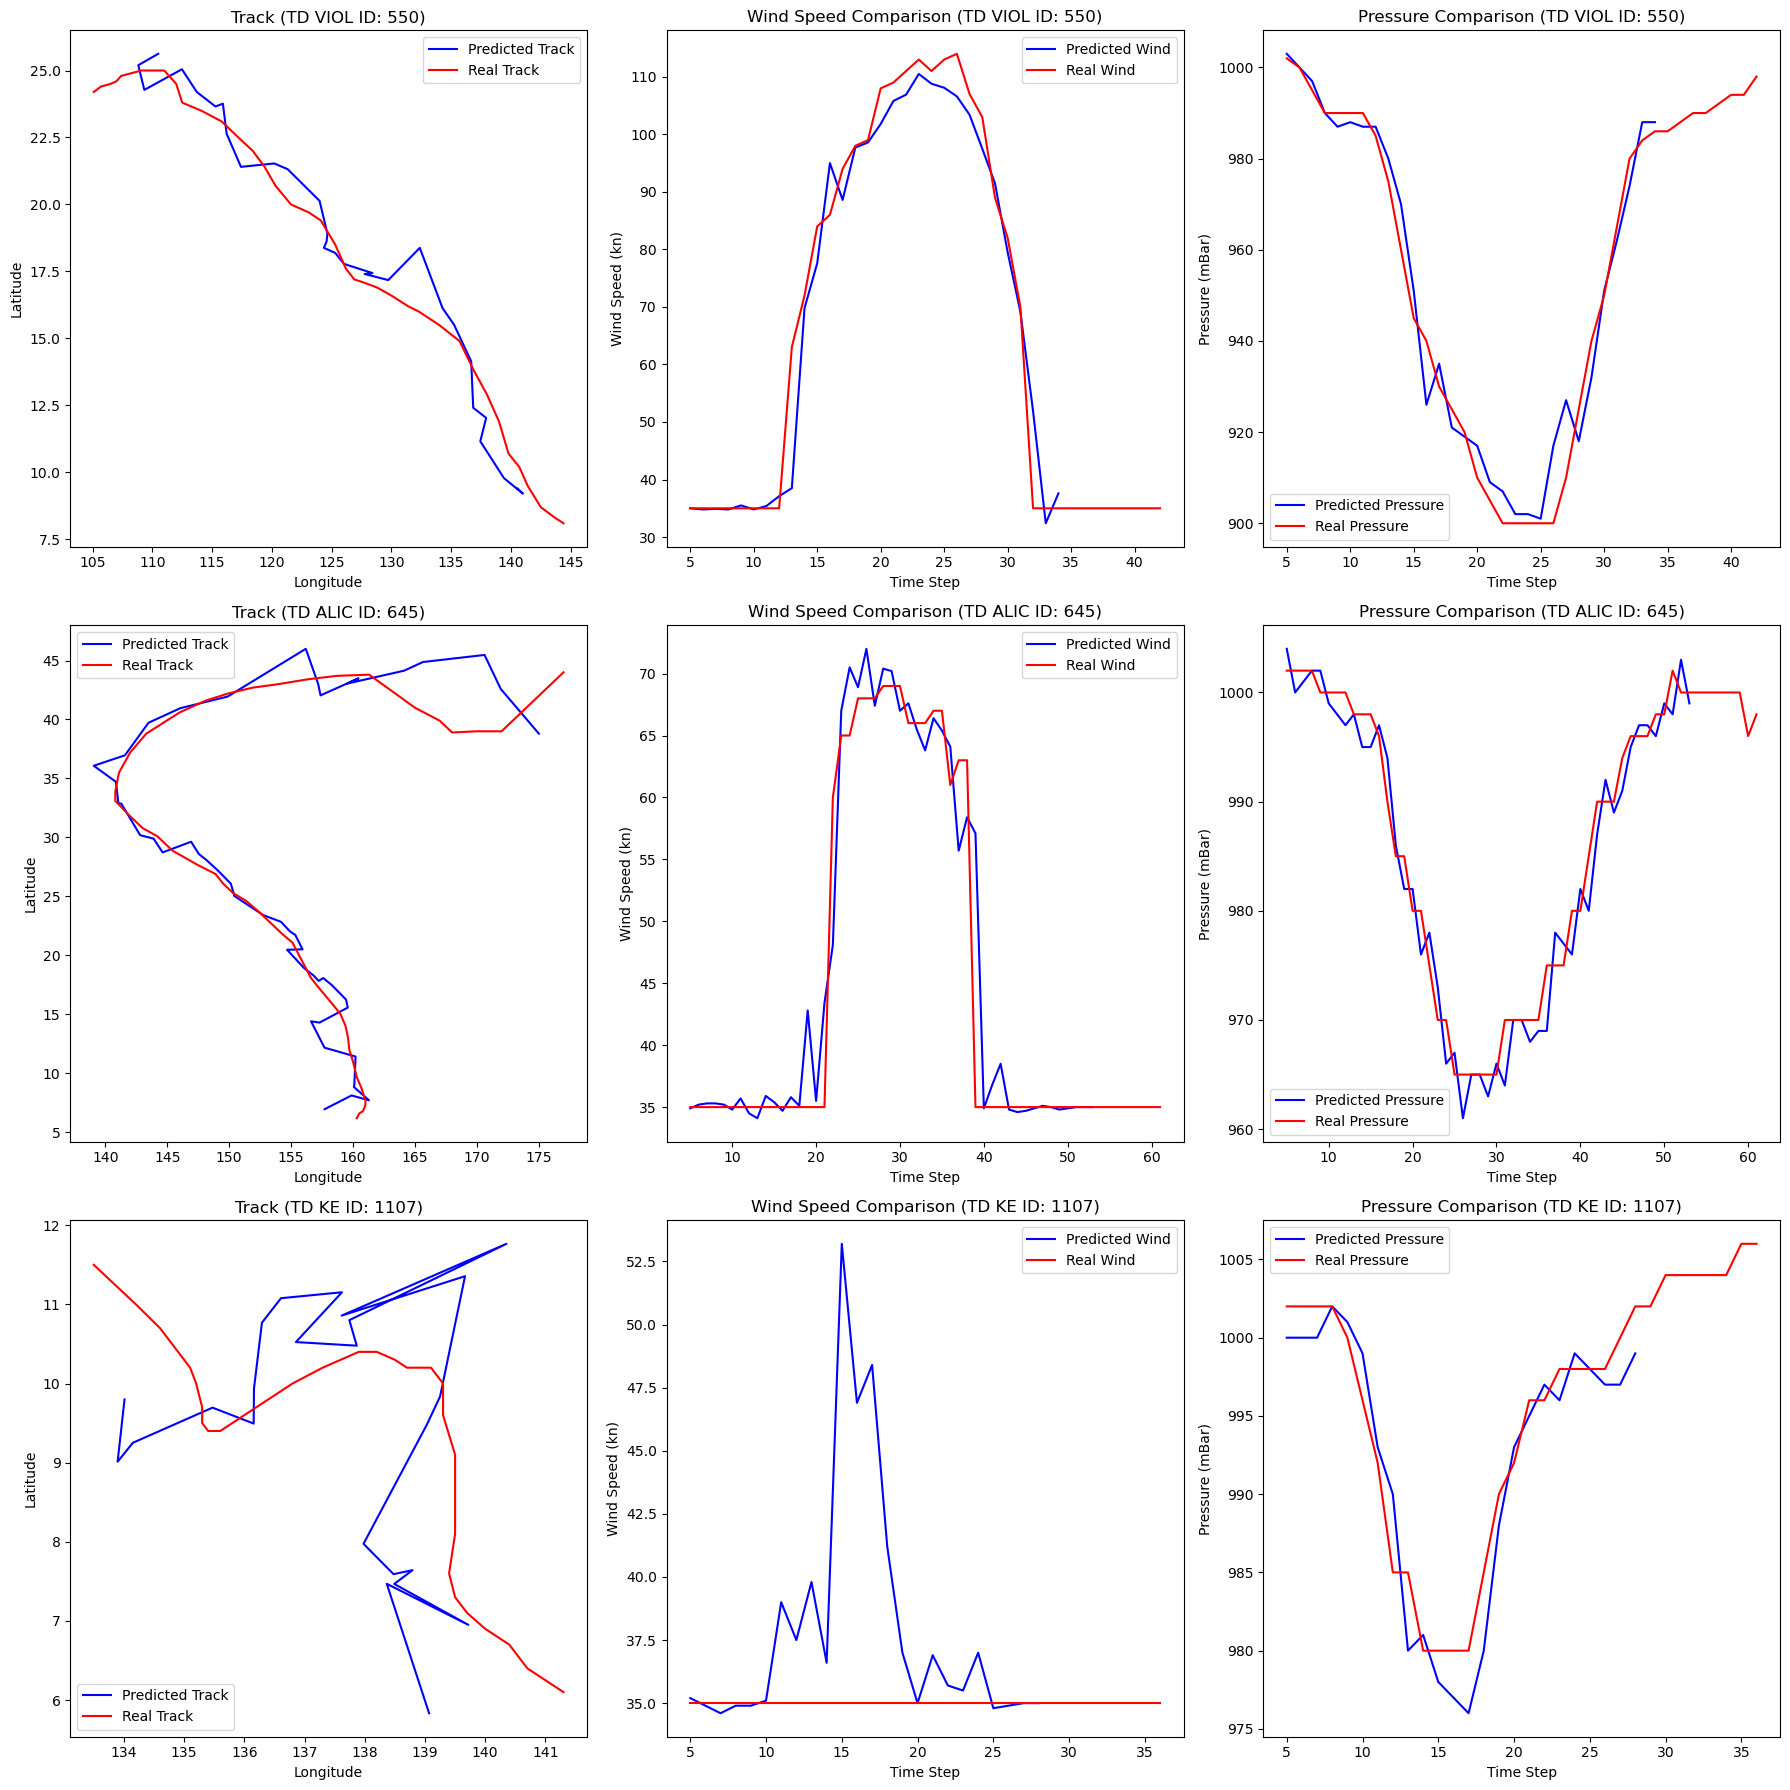

In [121]:
plot_tds(jma, X_test, best_pipeline_jma_24, 3, 97)

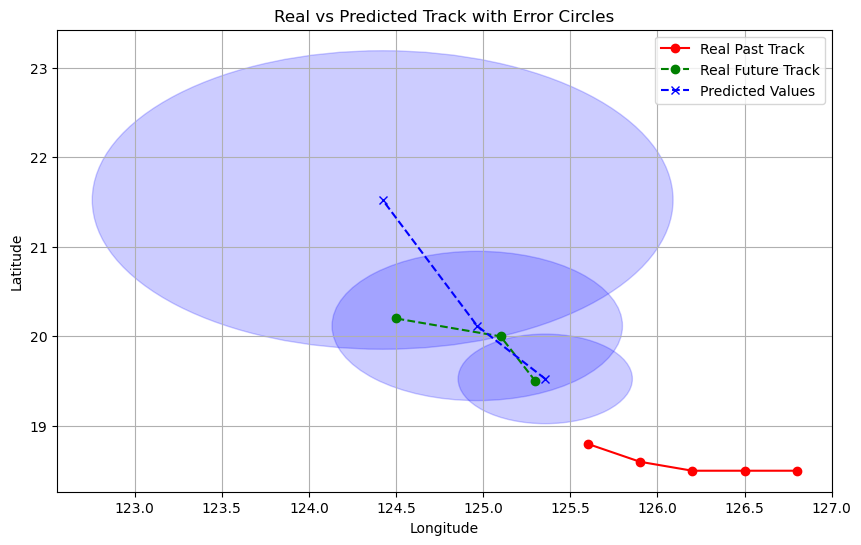

In [122]:
# Get predicted data
predicted_data = get_predicted_data(lagged_row, models=[pipeline_jma_6, pipeline_jma_12, best_pipeline_jma_24])

# Plot with error circles
plot_with_error_circles(real_past, real_future, predicted_data)

In [123]:
pipeline_jma_24.predict(lagged_row)

array([[  21.335764,  124.07632 ,   35.231216, 1004.9202  ]],
      dtype=float32)

In [124]:
best_pipeline_jma_24.predict(lagged_row)

array([[  21.522951,  124.42328 ,   34.877922, 1005.8814  ]],
      dtype=float32)

In [125]:
predicted_data

,lat,lon,max_wind_kn,min_pressure_mBar
time,,,,
2023-08-23 18:00:00,19.525358,125.356316,34.802132,1004.904419
2023-08-24 00:00:00,20.116455,124.966141,35.093575,1005.278564
2023-08-24 12:00:00,21.522951,124.423279,34.877922,1005.881409


In [126]:
real_future

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
2023-08-23 18:00:00,2222,SAOL,19.5,125.3,35,1004,-1,5.3,339.0
2023-08-24 00:00:00,2222,SAOL,20.0,125.1,35,1006,-1,5.7,331.0
2023-08-24 12:00:00,2222,SAOL,20.2,124.5,35,1002,-1,2.1,242.0


[CV 3/3] END regressor__estimator__colsample_bytree=0.9881675374476422, regressor__estimator__learning_rate=0.19583039501954724, regressor__estimator__max_depth=8, regressor__estimator__n_estimators=208, regressor__estimator__reg_alpha=3.451435172216195, regressor__estimator__reg_lambda=2.124000498720313, regressor__estimator__subsample=0.6494300534589852;, score=-11.749 total time=  24.6s
[CV 1/3] END regressor__estimator__colsample_bytree=0.9881675374476422, regressor__estimator__learning_rate=0.19583039501954724, regressor__estimator__max_depth=8, regressor__estimator__n_estimators=208, regressor__estimator__reg_alpha=3.451435172216195, regressor__estimator__reg_lambda=2.124000498720313, regressor__estimator__subsample=0.6494300534589852;, score=-14.178 total time=  24.9s
[CV 2/3] END regressor__estimator__colsample_bytree=0.9881675374476422, regressor__estimator__learning_rate=0.19583039501954724, regressor__estimator__max_depth=8, regressor__estimator__n_estimators=208, regressor_

#### Optimization Conclusion
The current model configuration provides robust predictions with satisfactory accuracy for both short-term and long-term forecasts. While further optimization could potentially improve performance marginally, the trade-off between time consumption and benefits does not justify extensive hypertuning in this context. Instead, efforts were directed toward analyzing model behavior, feature importance, and visualization for better interpretability and practical application.

## Final Conclusion: General Performance of the Models for 6, 12, and 24-hour Predictions

The evaluation of the prediction models for 6, 12, and 24-hour forecasts highlights the strengths and limitations of the approach:

1. **6-Hour Predictions**:
   - The model consistently achieves high accuracy, with most predicted positions falling within a 30 NM radius of the real positions.
   - This strong performance indicates that the model effectively captures short-term dynamics of tropical depression tracks and intensity changes.
   - The proximity of predictions to actual positions suggests the feature engineering (e.g., lagged data) and the inclusion of key variables (e.g., ENSO phase, wind speed, pressure) are well-suited for this time frame.

2. **12-Hour Predictions**:
   - The accuracy slightly decreases compared to 6-hour forecasts, as evidenced by a broader spread of predicted positions and higher errors.
   - While the majority of predictions fall within a 50 NM radius, the increase in uncertainty reflects the compounding effect of errors over time.
   - The performance remains robust for operational use, but the diminishing accuracy highlights the model's challenges in capturing mid-term trajectory changes.

3. **24-Hour Predictions**:
   - The model exhibits the lowest accuracy in this time frame, with a significant increase in error variance. Predictions frequently fall outside the 100 NM radius.
   - This suggests that while the model captures broad patterns, it struggles to account for long-term environmental factors and complex interactions influencing tropical depression tracks.
   - These challenges are expected, as longer time horizons naturally introduce greater uncertainty in both the initial conditions and external influences.

---

### Overall Insights
- The models demonstrate strong performance for short-term predictions (6 hours) and reasonable accuracy for mid-term forecasts (12 hours). However, accuracy decreases substantially for long-term predictions (24 hours), indicating the need for further refinement.
- The error distribution and feature importance analysis suggest that the models effectively utilize lagged features and key atmospheric variables but may benefit from additional long-term predictors, such as global wind patterns or ocean surface temperatures.
- For practical applications, the models are reliable for short- and medium-term forecasts but may require supplementary methods (e.g., ensemble predictions or probabilistic approaches) for longer time horizons.

This analysis provides a solid foundation for enhancing the models to improve long-term prediction accuracy while maintaining their robustness for shorter intervals.